In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns
import warnings 
import numpy as np
import pymysql

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings('ignore')

import matplotlib.font_manager as fm
# 폰트 경로에서 FontProperties 객체 만들기
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'
fontprop = fm.FontProperties(fname=font_path)

# 전역 설정에 적용
plt.rcParams['font.family'] = fontprop.get_name()

# 유저 출석 파트

### 유저 별 출석 횟수, 최종 출석일 등 확인하기

In [ ]:
user_attendance = pd.read_csv("./data/user_attendance.csv", encoding="utf-8")
user_attendance

,user_id,attendance_date
0,1446852,2023-05-27
1,1359398,2023-05-27
2,1501542,2023-05-27
3,1507767,2023-05-27
4,1287453,2023-05-27
...,...,...
2222322,1499325,2024-05-05
2222323,1499325,2024-05-06
2222324,1499325,2024-05-07
2222325,1499325,2024-05-08


In [ ]:
# 유저별 출석 횟수
user_attendance["user_id"].value_counts()

user_id
1499325    310
1314665    302
1467385    277
1491003    274
1467221    273
          ... 
1534810      1
1523817      1
1366519      1
1462939      1
1583730      1
Name: count, Length: 328692, dtype: int64

In [ ]:
user_attendance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2222327 entries, 0 to 2222326
Data columns (total 2 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   user_id          int64 
 1   attendance_date  object
dtypes: int64(1), object(1)
memory usage: 33.9+ MB


In [ ]:
# attendance_date 컬럼을 datetime 형식으로 변환
user_attendance['attendance_date'] = pd.to_datetime(user_attendance['attendance_date'])

In [ ]:
user_attendance

,user_id,attendance_date
0,1446852,2023-05-27
1,1359398,2023-05-27
2,1501542,2023-05-27
3,1507767,2023-05-27
4,1287453,2023-05-27
...,...,...
2222322,1499325,2024-05-05
2222323,1499325,2024-05-06
2222324,1499325,2024-05-07
2222325,1499325,2024-05-08


In [ ]:
user_attendance.describe()

,user_id,attendance_date
count,2.222327e+06,2222327
mean,1.258590e+06,2023-06-17 23:42:28.812124672
min,8.321510e+05,2023-05-27 00:00:00
25%,1.087754e+06,2023-05-31 00:00:00
50%,1.279069e+06,2023-06-06 00:00:00
75%,1.442944e+06,2023-06-19 00:00:00
max,1.583730e+06,2024-05-09 00:00:00
std,2.073201e+05,NaN


In [ ]:
# 최초, 최종 출석일 구하기 
user_attendance_summary = user_attendance.groupby('user_id').agg(
    first_date=('attendance_date', 'min'),
    last_date=('attendance_date', 'max')
).reset_index()

user_attendance_summary

,user_id,first_date,last_date
0,832151,2023-05-29,2023-05-29
1,832340,2023-06-05,2023-06-06
2,832986,2023-05-28,2023-05-28
3,833041,2023-05-27,2024-02-09
4,833112,2023-09-18,2023-09-24
...,...,...,...
328687,1583708,2024-05-06,2024-05-06
328688,1583710,2024-05-05,2024-05-05
328689,1583715,2024-05-05,2024-05-05
328690,1583727,2024-05-09,2024-05-09


In [ ]:
## 유저별 출석 간격 계산하기 
# 유저별로 출석일 순서대로 정렬하기
user_attendance_sorted = user_attendance.sort_values(by = ['user_id', 'attendance_date']).copy()
# 출석일 간격 계산하기 - 이전 출석일과의 차이로 계산하기
user_attendance_sorted['prev_date'] = user_attendance_sorted.groupby('user_id')['attendance_date'].shift(1)
# 출석일 간격 계산하기 - timedelta 형식으로 계산하기
user_attendance_sorted["attendance_interval"] = (user_attendance_sorted["attendance_date"] - user_attendance_sorted["prev_date"]).dt.days

user_attendance_sorted.head(20)

,user_id,attendance_date,prev_date,attendance_interval
204530,832151,2023-05-29,NaT,NaN
292875,832340,2023-06-05,NaT,NaN
563598,832340,2023-06-06,2023-06-05,1.0
126085,832986,2023-05-28,NaT,NaN
55892,833041,2023-05-27,NaT,NaN
380157,833041,2023-05-28,2023-05-27,1.0
625499,833041,2023-05-29,2023-05-28,1.0
824544,833041,2023-05-30,2023-05-29,1.0
991849,833041,2023-05-31,2023-05-30,1.0
1135154,833041,2023-06-02,2023-05-31,2.0


In [ ]:
## 월별 출석 간격 변화 확인하기 
# 월 정보 추출 
user_attendance_sorted['month'] = user_attendance_sorted['attendance_date'].dt.to_period('M')
# 월 평균 출석 간격계산 
monthly_gap = (user_attendance_sorted[user_attendance_sorted['attendance_interval'].notna()] # 평균 계산 위해 attendance_interval에서 NaN 값(첫 출석일에 대한 행이라서 발생) 제거 
                                .groupby('month')['attendance_interval'].mean() 
                                .reset_index(name = 'monthly_gap'))

monthly_gap

,month,monthly_gap
0,2023-05,1.179945
1,2023-06,2.229966
2,2023-07,8.126635
3,2023-08,11.046421
4,2023-09,35.609080
5,2023-10,23.569599
6,2023-11,38.828459
7,2023-12,39.630568
8,2024-01,64.857222
9,2024-02,61.877422


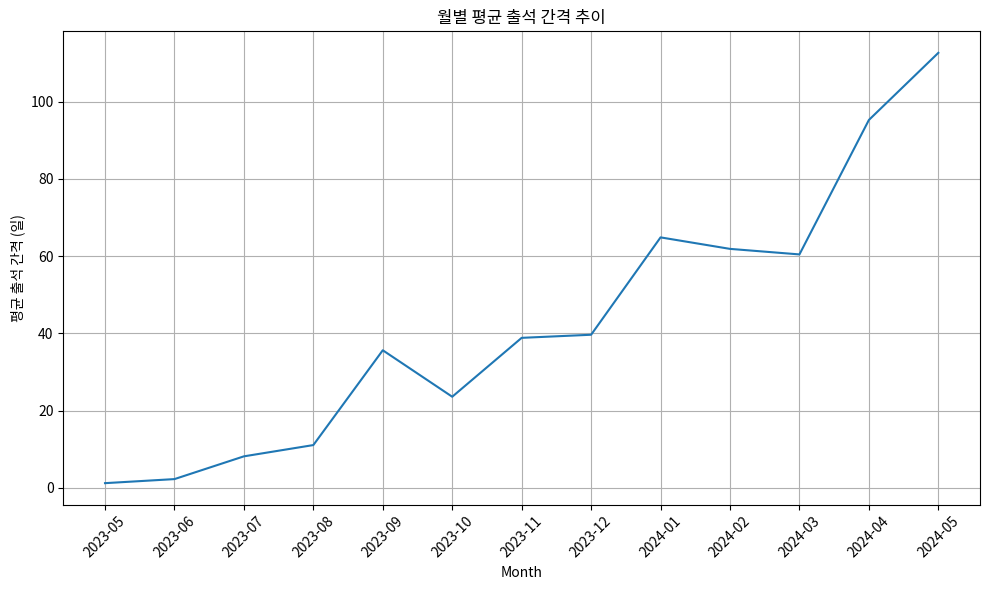

In [ ]:
# 월별 출석 간격 추이
plt.figure(figsize=(10, 6))
plt.plot(monthly_gap['month'].astype(str), monthly_gap['monthly_gap'])
plt.title('월별 평균 출석 간격 추이')
plt.xlabel('Month')
plt.ylabel('평균 출석 간격 (일)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
## 유져별 평균 출석 간격 계산하기 (첫 출석일에는 간격이 없으니 제외하여 평균)
avg_gap = user_attendance_sorted.groupby("user_id")["attendance_interval"].mean().reset_index()
avg_gap.columns = ["user_id", "avg_attendance_gap_days"]

# 최초, 최종 출석일과 유저별 평균 출석 간격을 통합하여 요약 테이블 만들기
user_attendance_summary = user_attendance_summary.merge(avg_gap, on="user_id", how="left")

# avg_attendance_gap_days 컬럼의 결측값을 0으로 대체하기
user_attendance_summary['avg_attendance_gap_days'] = user_attendance_summary['avg_attendance_gap_days'].fillna(0)

user_attendance_summary.head(20)

,user_id,first_date,last_date,avg_attendance_gap_days
0,832151,2023-05-29,2023-05-29,0.000000
1,832340,2023-06-05,2023-06-06,1.000000
2,832986,2023-05-28,2023-05-28,0.000000
3,833041,2023-05-27,2024-02-09,4.961538
4,833112,2023-09-18,2023-09-24,3.000000
5,833154,2023-05-30,2023-05-30,0.000000
6,833202,2023-05-31,2023-06-23,23.000000
7,833203,2023-05-27,2023-09-23,17.000000
8,833294,2023-05-28,2023-06-05,1.333333
9,833303,2023-05-27,2023-09-16,4.869565


In [ ]:
# 유저별 출석 일 수 집계 
attendance_counts = user_attendance.groupby('user_id').size().reset_index(name='attendance_counts')
# user_attendance_summary에 유저별 출석 일 수 추가하기 
user_attendance_summary = user_attendance_summary.merge(attendance_counts, on='user_id', how='left')

user_attendance_summary.head(20)

,user_id,first_date,last_date,avg_attendance_gap_days,attendance_counts
0,832151,2023-05-29,2023-05-29,0.000000,1
1,832340,2023-06-05,2023-06-06,1.000000,2
2,832986,2023-05-28,2023-05-28,0.000000,1
3,833041,2023-05-27,2024-02-09,4.961538,53
4,833112,2023-09-18,2023-09-24,3.000000,3
5,833154,2023-05-30,2023-05-30,0.000000,1
6,833202,2023-05-31,2023-06-23,23.000000,2
7,833203,2023-05-27,2023-09-23,17.000000,8
8,833294,2023-05-28,2023-06-05,1.333333,7
9,833303,2023-05-27,2023-09-16,4.869565,24


In [ ]:
user_attendance_summary.describe()

,user_id,first_date,last_date,avg_attendance_gap_days,attendance_counts
count,3.286920e+05,328692,328692,328692.000000,328692.000000
mean,1.246004e+06,2023-06-03 05:13:37.100507392,2023-06-30 04:34:26.605819648,5.762978,6.761123
min,8.321510e+05,2023-05-27 00:00:00,2023-05-27 00:00:00,0.000000,1.000000
25%,1.065784e+06,2023-05-28 00:00:00,2023-06-01 00:00:00,1.000000,2.000000
50%,1.260389e+06,2023-05-29 00:00:00,2023-06-08 00:00:00,1.714286,4.000000
75%,1.434592e+06,2023-05-30 00:00:00,2023-07-08 00:00:00,4.000000,9.000000
max,1.583730e+06,2024-05-09 00:00:00,2024-05-09 00:00:00,345.000000,310.000000
std,2.116482e+05,NaN,NaN,15.659977,9.299667


- 전체 최초 출석일은 2023-05-27, 최종 출석일은 2024-05-09 로 집계됨. 
    - 데이터 집계가 23년 5월부터 24년 5월까지라면, 해당 출석일 전후로는 전혀 집계되지 않은 건지 확인이 필요할 듯
    - 집계 기간 최소 1년.
- 평균 출석일 수 = 6.7일, 출석 간격 = 5.7일
- 1년 간 10일 이상 출석하지 않은 인원이 75%, 나머지 인원은 최대 310일까지 출석하지만, 대부분 200일 이내 
- 출석 일 수와 평균 출석 간격이 대부분 10일 내에 분포하긴 하지만, 최댓값까지 이용자 수가 없는 것은 아님. 

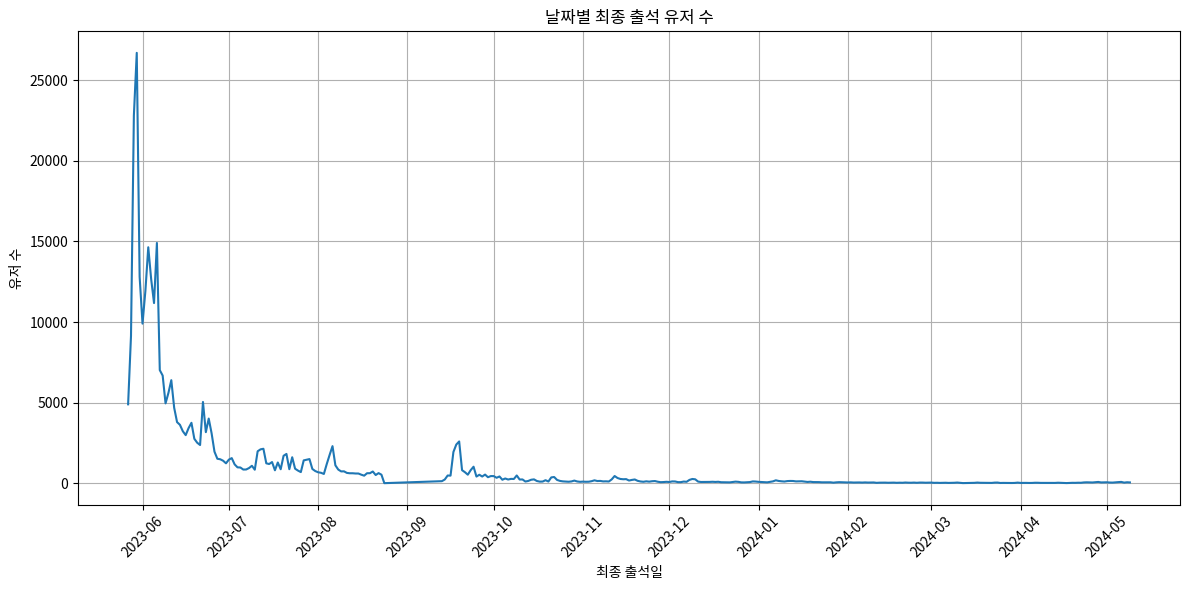

In [ ]:
# 날짜별로 마지막 출석일자 기준 집계
last_day_counts = user_attendance_summary.groupby("last_date").size().reset_index(name="user_count")

# 날짜 오름차순 정렬
last_day_counts = last_day_counts.sort_values("last_date")

# 날짜별 최종 유저 수 집계
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(last_day_counts["last_date"], last_day_counts["user_count"])
plt.title("날짜별 최종 출석 유저 수")
plt.xlabel("최종 출석일")
plt.ylabel("유저 수")

plt.gca().xaxis.set_major_locator(mdates.MonthLocator()) # x축 눈금 한 달 간격으로 설정
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


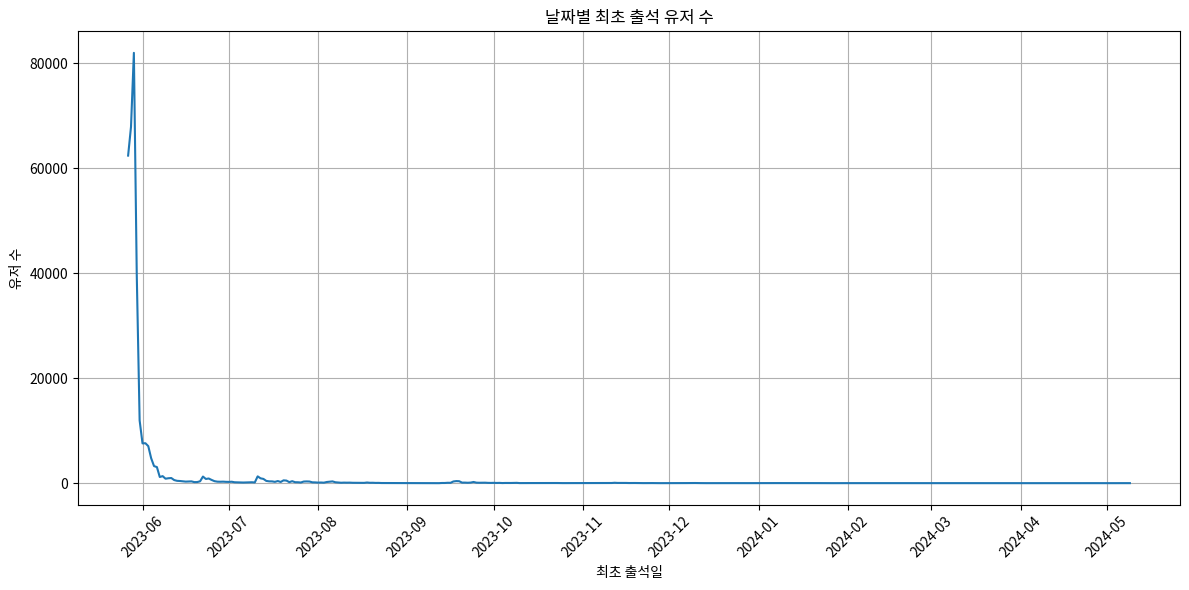

In [ ]:
# 날짜별로 첫번째 출석일자 기준 집계
first_day_counts = user_attendance_summary.groupby("first_date").size().reset_index(name="user_count")

# 날짜 오름차순 정렬
first_day_counts = first_day_counts.sort_values("first_date")

# 날짜별 최종 유저 수 집계
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(first_day_counts["first_date"], first_day_counts["user_count"])
plt.title("날짜별 최초 출석 유저 수")
plt.xlabel("최초 출석일")
plt.ylabel("유저 수")

plt.gca().xaxis.set_major_locator(mdates.MonthLocator()) # x축 눈금 한 달 간격으로 설정
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

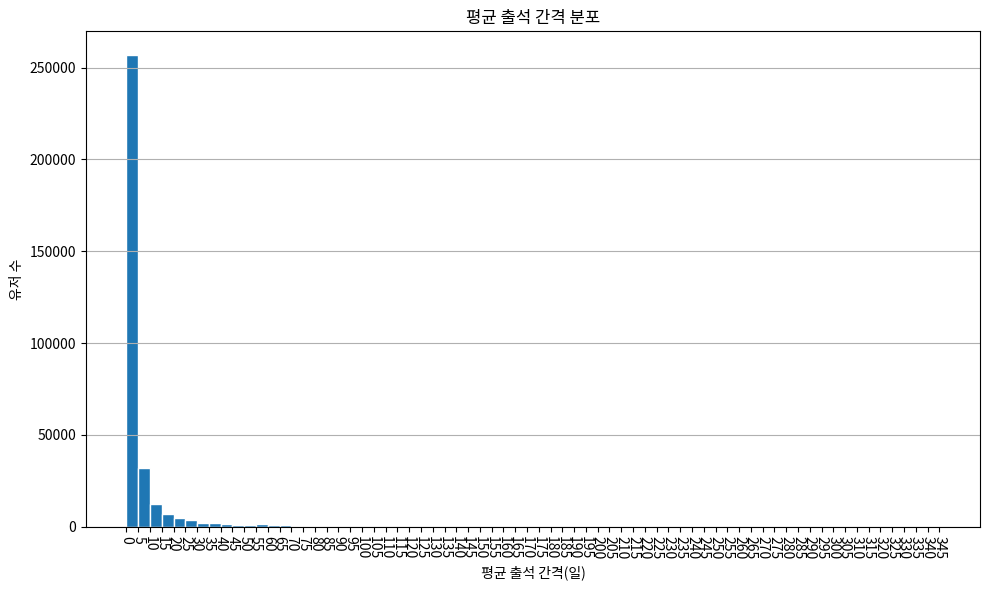

In [ ]:
# 유저별 평균 출석 간격 분포 시각화(히스토그램)
# x축 값 범위 확인
min_val = user_attendance_summary['avg_attendance_gap_days'].min()
max_val = user_attendance_summary['avg_attendance_gap_days'].max()

# 5일 단위로 bin 경계 생성
bins = np.arange(0, max_val + 5, 5)

plt.figure(figsize=(10, 6))
plt.hist(user_attendance_summary['avg_attendance_gap_days'].dropna(), bins=bins, edgecolor='white')
plt.title('평균 출석 간격 분포')
plt.xlabel('평균 출석 간격(일)')
plt.ylabel('유저 수')
plt.xticks(bins, rotation = -90)  # x축 눈금도 5일 단위로 설정
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


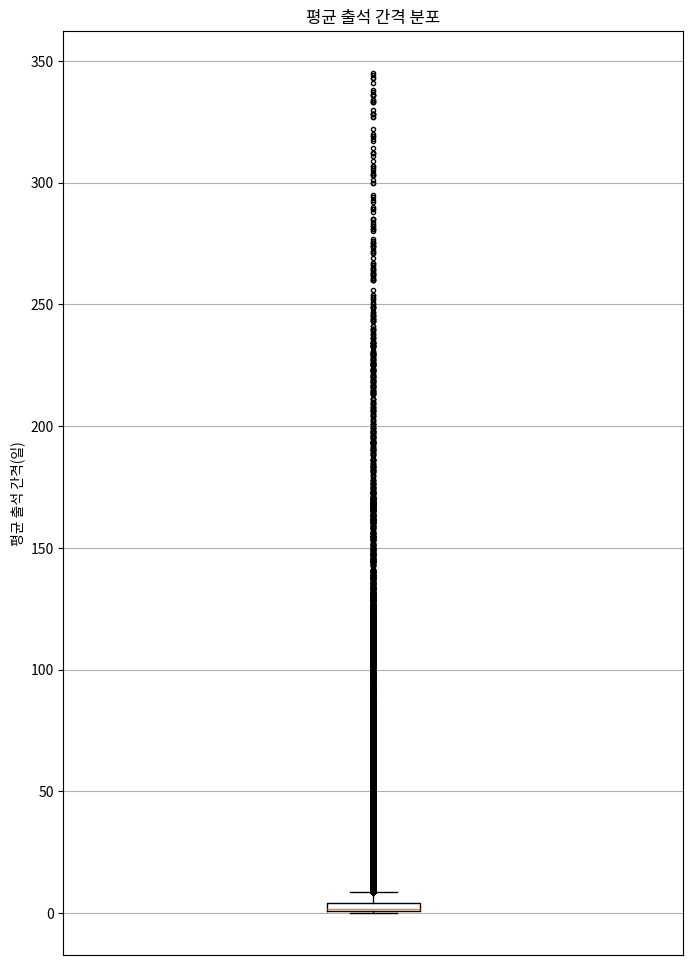

In [ ]:
# 유저별 평균 출석 간격 분포 시각화
plt.figure(figsize=(8,12))

# 박스플롯의 이상치 마커 크기 설정 
flier_props = dict(marker='o', markersize=3, linestyle='none')
plt.boxplot(user_attendance_summary['avg_attendance_gap_days'].dropna(), vert=True, flierprops = flier_props)
plt.title('평균 출석 간격 분포')
plt.ylabel('평균 출석 간격(일)')
plt.xticks([])  # x축 눈금 제거
plt.grid(True)
plt.show()


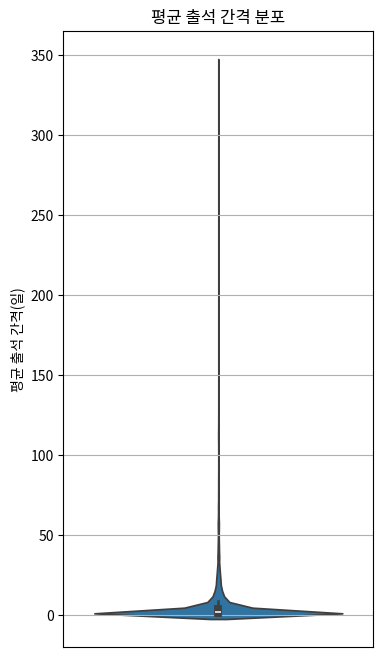

In [ ]:
# 유저별 평균 출석 간격 분포 시각화: 바이올린 플랏
plt.figure(figsize=(4, 8))
sns.violinplot(
    y=user_attendance_summary['avg_attendance_gap_days'],
    inner='box'  # 박스플롯 추가가
    #color='skyblue'
)
plt.title('평균 출석 간격 분포')
plt.ylabel('평균 출석 간격(일)')
plt.xticks([])
plt.grid(True, axis='y')
plt.show()


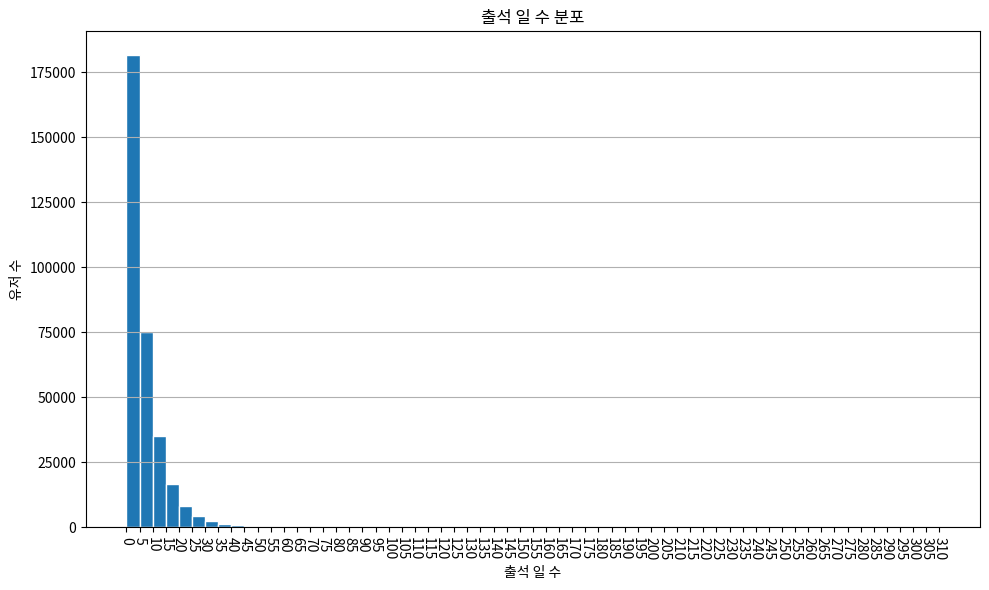

In [ ]:
# 유저별 평균 출석 일 수 분포 시각화 (히스토그램)
# bin 경계 설정 (예: 5일 간격)
max_days = user_attendance_summary['attendance_counts'].max()
bins = np.arange(0, max_days + 5, 5)

plt.figure(figsize=(10, 6))
plt.hist(user_attendance_summary['attendance_counts'].dropna(), bins=bins, edgecolor='white')
plt.title('출석 일 수 분포')
plt.xlabel('출석 일 수')
plt.ylabel('유저 수')
plt.xticks(bins, rotation=-90)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


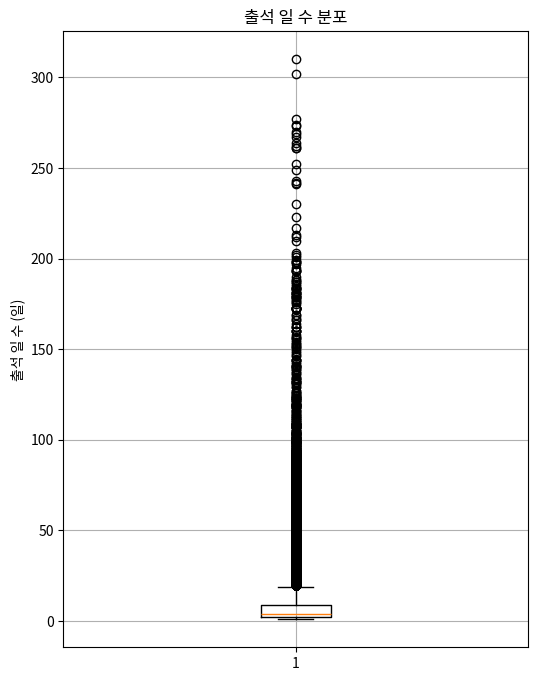

In [ ]:
# 유저별 평균 출석 일 수 분포 시각화(boxplot)
plt.figure(figsize=(6, 8))
plt.boxplot(user_attendance_summary['attendance_counts'].dropna(), vert=True)
plt.title('출석 일 수 분포')
plt.ylabel('출석 일 수 (일)')
plt.grid(True)
plt.show()


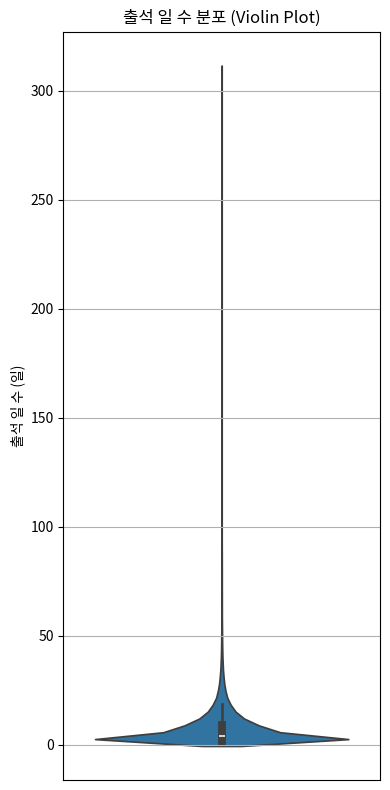

In [ ]:
# 유저별 평균 출석 일 수 분포 시각화: 바이올린 분포
plt.figure(figsize=(4, 8))
sns.violinplot(
    y=user_attendance_summary['attendance_counts'],
    inner='box'
    # color='lightblue'     
)

plt.title('출석 일 수 분포 (Violin Plot)')
plt.ylabel('출석 일 수 (일)')
plt.xticks([])            
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


### DAU, MAU, 고착도 확인하기
- `DAU(Daily Active Users)`: 하루동안 서비스에 접속한 순사용자 수
- `MAU(Monthly Active Users)`: 한 달 동안 한 번이라도 접속한 순사용자 수
- `고착도(Stickiness)` = `DAU/MAU` : 한 달을 기준으로 일일 사용자 비율, 즉 얼마나 자주 들어오는지 보여주는 지표 

In [ ]:
user_attendance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2222327 entries, 0 to 2222326
Data columns (total 2 columns):
 #   Column           Dtype         
---  ------           -----         
 0   user_id          int64         
 1   attendance_date  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 33.9 MB


In [ ]:
# MAU를 위해 월 컬럼 생성하기
user_attendance['month'] = user_attendance['attendance_date'].dt.to_period('M')

user_attendance.head(20)

,user_id,attendance_date,month
0,1446852,2023-05-27,2023-05
1,1359398,2023-05-27,2023-05
2,1501542,2023-05-27,2023-05
3,1507767,2023-05-27,2023-05
4,1287453,2023-05-27,2023-05
5,1394716,2023-05-29,2023-05
6,1232022,2023-05-27,2023-05
7,1497112,2023-05-27,2023-05
8,1449303,2023-05-27,2023-05
9,1406666,2023-05-27,2023-05


In [ ]:
# DAU 계산하기 
dau = user_attendance.groupby('attendance_date')['user_id'] \
                .nunique() \
                .reset_index(name = 'DAU')

dau

,attendance_date,DAU
0,2023-05-27,62417
1,2023-05-28,94220
2,2023-05-29,172836
3,2023-05-30,166052
4,2023-05-31,115713
...,...,...
328,2024-05-05,107
329,2024-05-06,110
330,2024-05-07,60
331,2024-05-08,68


In [ ]:
# MAU 계산하기
mau = user_attendance.groupby('month')['user_id'] \
                .nunique() \
                .reset_index(name = 'MAU')

mau

,month,MAU
0,2023-05,264049
1,2023-06,226928
2,2023-07,61836
3,2023-08,28314
4,2023-09,20482
5,2023-10,9011
6,2023-11,6050
7,2023-12,3612
8,2024-01,3072
9,2024-02,1191


In [ ]:
## 고착도 계산하기 
# DAU에 월 정보 추가하기(머지하기 위해)
dau['month'] = dau['attendance_date'].dt.to_period('M')
# DAU와 MAU를 머지하기
dau_mau = dau.merge(mau, on = 'month', how = 'left')
# 고착도 계산하기
dau_mau['stickiness'] = dau_mau['DAU'] / dau_mau['MAU'] 

dau_mau

,attendance_date,DAU,month,MAU,stickiness
0,2023-05-27,62417,2023-05,264049,0.236384
1,2023-05-28,94220,2023-05,264049,0.356828
2,2023-05-29,172836,2023-05,264049,0.654560
3,2023-05-30,166052,2023-05,264049,0.628868
4,2023-05-31,115713,2023-05,264049,0.438225
...,...,...,...,...,...
328,2024-05-05,107,2024-05,464,0.230603
329,2024-05-06,110,2024-05,464,0.237069
330,2024-05-07,60,2024-05,464,0.129310
331,2024-05-08,68,2024-05,464,0.146552


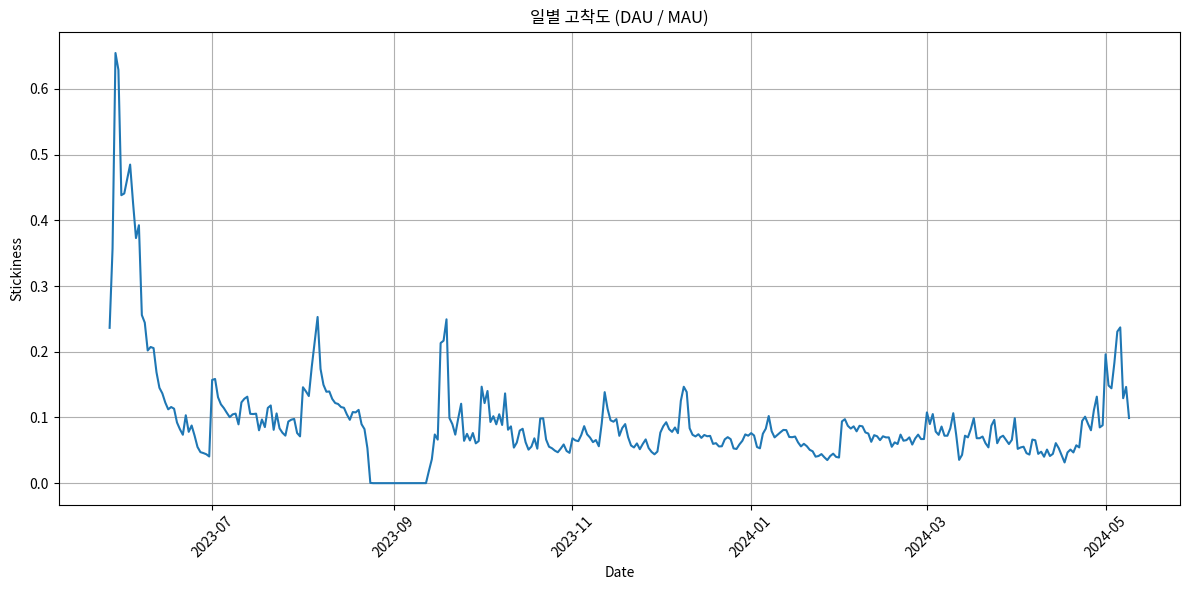

In [ ]:
# 고착도 시각화하기
plt.figure(figsize=(12, 6))
plt.plot(dau_mau['attendance_date'], dau_mau['stickiness'], linestyle='-')
plt.title('일별 고착도 (DAU / MAU)')
plt.xlabel('Date')
plt.ylabel('Stickiness')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
dau_mau[(dau_mau['attendance_date'].dt.month == 8) & (dau_mau['attendance_date'].dt.year == 2023)]

,attendance_date,DAU,month,MAU,stickiness
66,2023-08-01,4133,2023-08,28314,0.145970
67,2023-08-02,3957,2023-08,28314,0.139754
68,2023-08-03,3755,2023-08,28314,0.132620
69,2023-08-04,5008,2023-08,28314,0.176874
70,2023-08-05,6099,2023-08,28314,0.215406
71,2023-08-06,7161,2023-08,28314,0.252914
72,2023-08-07,4924,2023-08,28314,0.173907
73,2023-08-08,4239,2023-08,28314,0.149714
74,2023-08-09,3940,2023-08,28314,0.139154
75,2023-08-10,3952,2023-08,28314,0.139578


In [ ]:
# 9월 일부 고착도가 왜 0이지?
dau_sep_2023 = dau_mau[(dau_mau['attendance_date'].dt.month == 9) & (dau_mau['attendance_date'].dt.year == 2023)]
dau_sep_2023

,attendance_date,DAU,month,MAU,stickiness
92,2023-09-12,2,2023-09,20482,0.000098
93,2023-09-13,385,2023-09,20482,0.018797
94,2023-09-14,748,2023-09,20482,0.036520
95,2023-09-15,1518,2023-09,20482,0.074114
96,2023-09-16,1358,2023-09,20482,0.066302
97,2023-09-17,4368,2023-09,20482,0.213260
98,2023-09-18,4441,2023-09,20482,0.216825
99,2023-09-19,5107,2023-09,20482,0.249341
100,2023-09-20,2031,2023-09,20482,0.099160
101,2023-09-21,1841,2023-09,20482,0.089884


In [ ]:
# 월별 평균 고착도 
monthly_stickiness = dau_mau.groupby('month')['stickiness'] \
    .mean() \
    .reset_index(name='avg_stickiness')
monthly_stickiness


,month,avg_stickiness
0,2023-05,0.462973
1,2023-06,0.181082
2,2023-07,0.104494
3,2023-08,0.116206
4,2023-09,0.092798
5,2023-10,0.078563
6,2023-11,0.072474
7,2023-12,0.077046
8,2024-01,0.060956
9,2024-02,0.073222


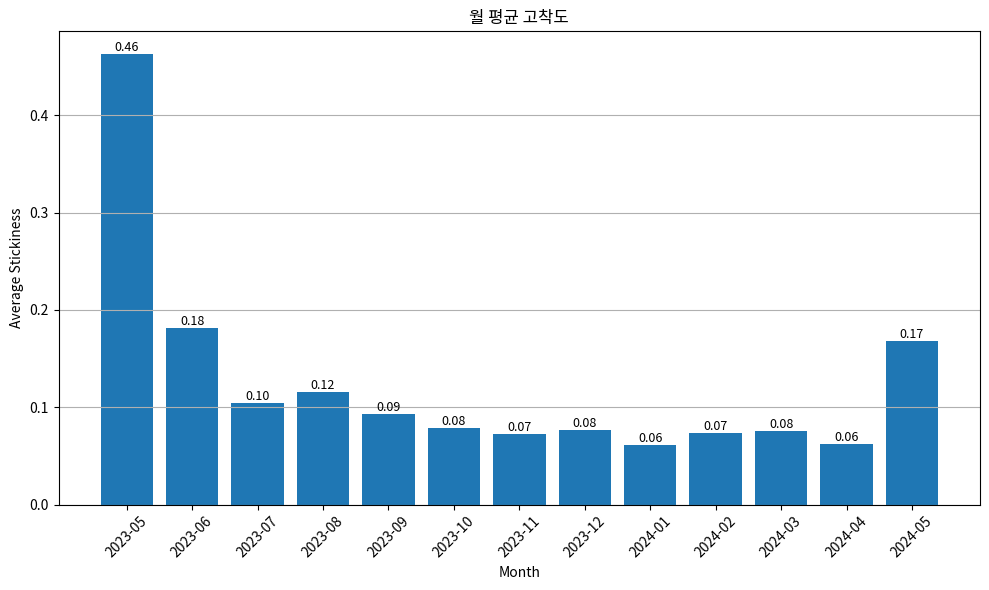

In [ ]:
# 월별 고착도 시각화 
plt.figure(figsize=(10, 6))
bars = plt.bar(monthly_stickiness['month'].astype(str), monthly_stickiness['avg_stickiness'])
plt.title('월 평균 고착도')
plt.xlabel('Month')
plt.ylabel('Average Stickiness')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()

# 막대 위에 수치 표시
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.2f}',            
        ha='center', va='bottom',  
        fontsize=9
    )

plt.show()

In [ ]:
## 주간 고착도 계산하기 
# dau_mau에 주 정보 추가하기
dau_mau['week'] = dau_mau['attendance_date'].dt.to_period('W')

# 주간 stickiness 계산하기
weekly_stickiness = dau_mau.groupby('week')['stickiness'] \
    .mean() \
    .reset_index(name='avg_stickiness')

weekly_stickiness.head(10)

,week,avg_stickiness
0,2023-05-22/2023-05-28,0.296606
1,2023-05-29/2023-06-04,0.505196
2,2023-06-05/2023-06-11,0.268611
3,2023-06-12/2023-06-18,0.130687
4,2023-06-19/2023-06-25,0.084251
5,2023-06-26/2023-07-02,0.078375
6,2023-07-03/2023-07-09,0.111879
7,2023-07-10/2023-07-16,0.112731
8,2023-07-17/2023-07-23,0.097562
9,2023-07-24/2023-07-30,0.085304


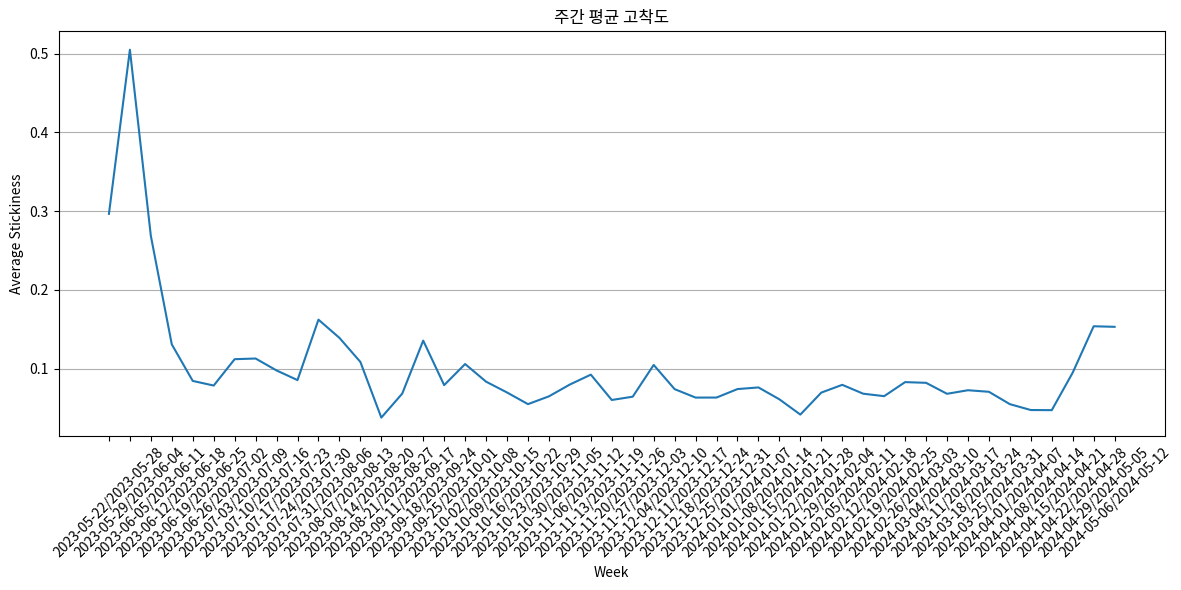

In [ ]:
# 주간 고착도 시각화하기 
plt.figure(figsize=(12, 6))
plt.plot(weekly_stickiness['week'].astype(str), weekly_stickiness['avg_stickiness'])
plt.title('주간 평균 고착도')
plt.xlabel('Week')
plt.ylabel('Average Stickiness')
plt.xticks(rotation=45)
plt.grid(True, axis = 'y')
plt.tight_layout()
plt.show()


In [ ]:
mau

,month,MAU
0,2023-05,264049
1,2023-06,226928
2,2023-07,61836
3,2023-08,28314
4,2023-09,20482
5,2023-10,9011
6,2023-11,6050
7,2023-12,3612
8,2024-01,3072
9,2024-02,1191


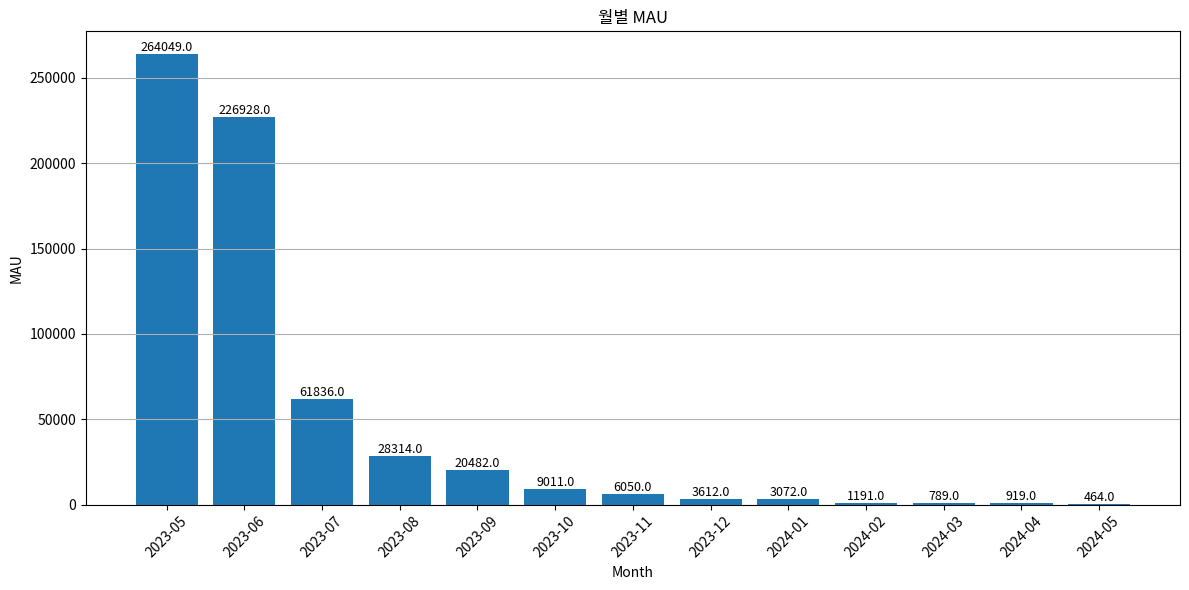

In [ ]:
# 기존 MAU 시각화 : 고착도 하락 원인인지 확인하기 위해 
plt.figure(figsize=(12, 6))
bars = plt.bar(mau['month'].astype(str),mau['MAU'])

plt.title('월별 MAU')
plt.xlabel('Month')
plt.ylabel('MAU')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()

# 막대 위에 수치 표시 
for bar in bars: 
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height:.1f}',            
            ha='center', va='bottom',  
            fontsize=9
        )

plt.show()

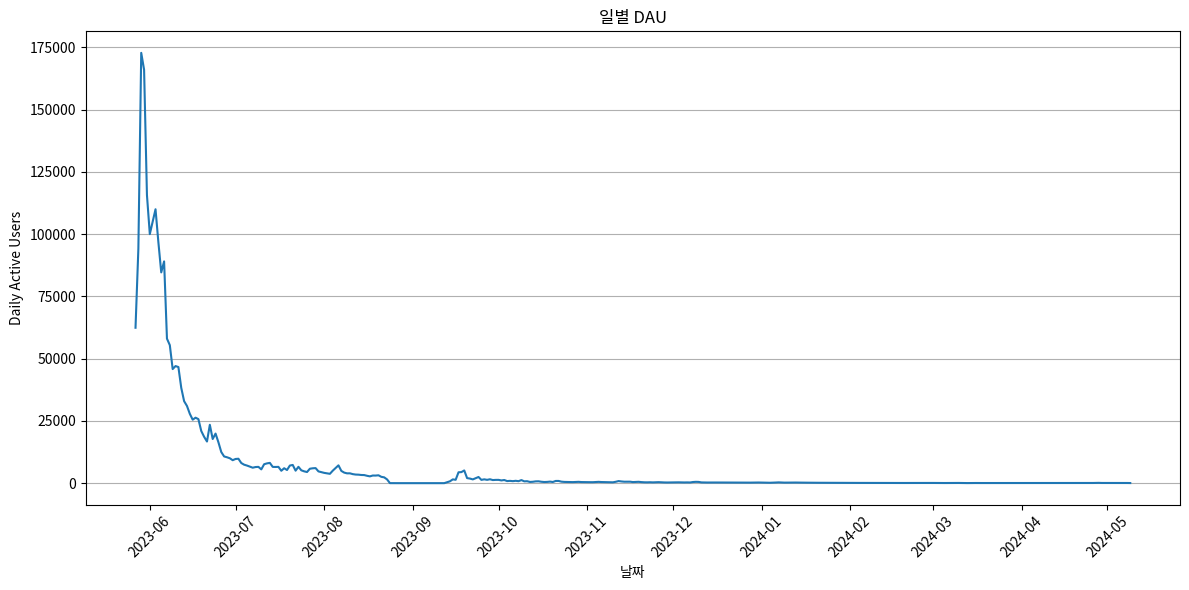

In [ ]:
# DAU 변화 
plt.figure(figsize=(12, 6))
plt.plot(dau_mau['attendance_date'], dau_mau['DAU'], linestyle='-')
plt.title('일별 DAU')
plt.xlabel('날짜')
plt.ylabel('Daily Active Users')
plt.grid(True, axis='y')

# x축을 월 단위로 깔끔하게
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 유저 탈퇴

In [ ]:
# csv 불러오기
user_withdraw = pd.read_csv("./data/accounts_userwithdraw.csv", encoding="utf-8")
user_withdraw

,id,reason,created_at
0,42,재밌는 질문이 없어서,2023-03-29 13:22:12
1,43,함께 할 친구가 없어서,2023-03-29 13:24:59
2,44,함께 할 친구가 없어서,2023-03-29 13:53:32
3,45,함께 할 친구가 없어서,2023-03-29 13:54:03
4,46,재밌는 질문이 없어서,2023-03-30 00:31:19
...,...,...,...
70759,70889,기타 이유,2024-05-08 14:24:16
70760,70890,함께 할 친구가 없어서,2024-05-08 15:20:06
70761,70891,재밌는 질문이 없어서,2024-05-08 15:46:36
70762,70892,기타 이유,2024-05-09 08:29:09


In [ ]:
user_withdraw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70764 entries, 0 to 70763
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          70764 non-null  int64 
 1   reason      70764 non-null  object
 2   created_at  70764 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


In [ ]:
# datetime 변환 
user_withdraw['created_at'] = pd.to_datetime(user_withdraw['created_at'])

In [ ]:
# 날짜 기준 컬럼 생성하기 
user_withdraw['date'] = user_withdraw['created_at'].dt.date
user_withdraw['week'] = user_withdraw['created_at'].dt.to_period('W').apply(lambda r: r.start_time) # 주 시작 날짜를 추출해 표기
user_withdraw['month'] = user_withdraw['created_at'].dt.to_period('M').dt.to_timestamp() # 시각화를 위해 timestamp로 변환 추출

user_withdraw

,id,reason,created_at,date,week,month
0,42,재밌는 질문이 없어서,2023-03-29 13:22:12,2023-03-29,2023-03-27,2023-03-01
1,43,함께 할 친구가 없어서,2023-03-29 13:24:59,2023-03-29,2023-03-27,2023-03-01
2,44,함께 할 친구가 없어서,2023-03-29 13:53:32,2023-03-29,2023-03-27,2023-03-01
3,45,함께 할 친구가 없어서,2023-03-29 13:54:03,2023-03-29,2023-03-27,2023-03-01
4,46,재밌는 질문이 없어서,2023-03-30 00:31:19,2023-03-30,2023-03-27,2023-03-01
...,...,...,...,...,...,...
70759,70889,기타 이유,2024-05-08 14:24:16,2024-05-08,2024-05-06,2024-05-01
70760,70890,함께 할 친구가 없어서,2024-05-08 15:20:06,2024-05-08,2024-05-06,2024-05-01
70761,70891,재밌는 질문이 없어서,2024-05-08 15:46:36,2024-05-08,2024-05-06,2024-05-01
70762,70892,기타 이유,2024-05-09 08:29:09,2024-05-09,2024-05-06,2024-05-01


In [ ]:
# 일별, 주별, 월별 탈퇴 수 집계하기 
daily_withdraw = user_withdraw.groupby('date').size()
weekly_withdraw = user_withdraw.groupby('week').size()
monthly_withdraw = user_withdraw.groupby('month').size()

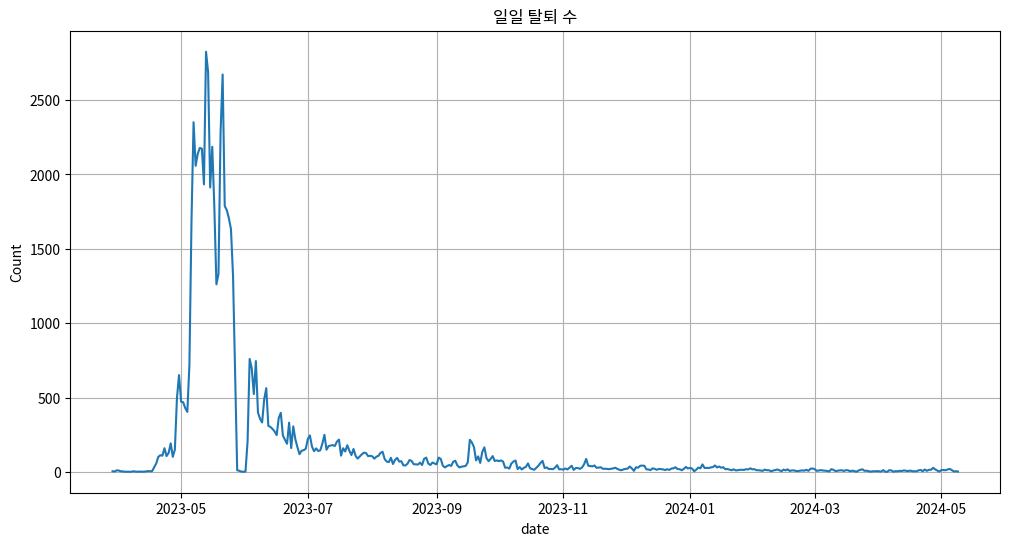

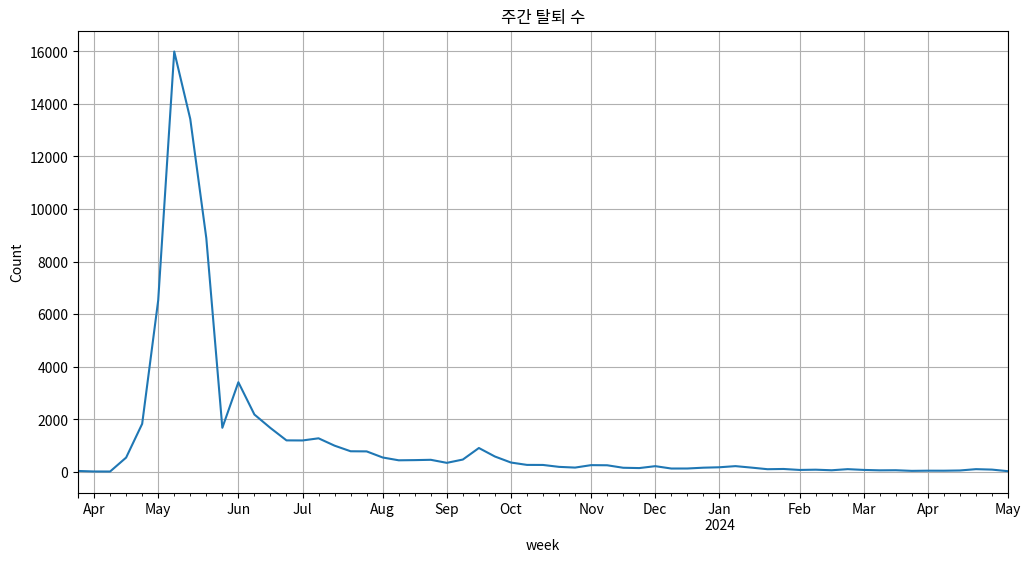

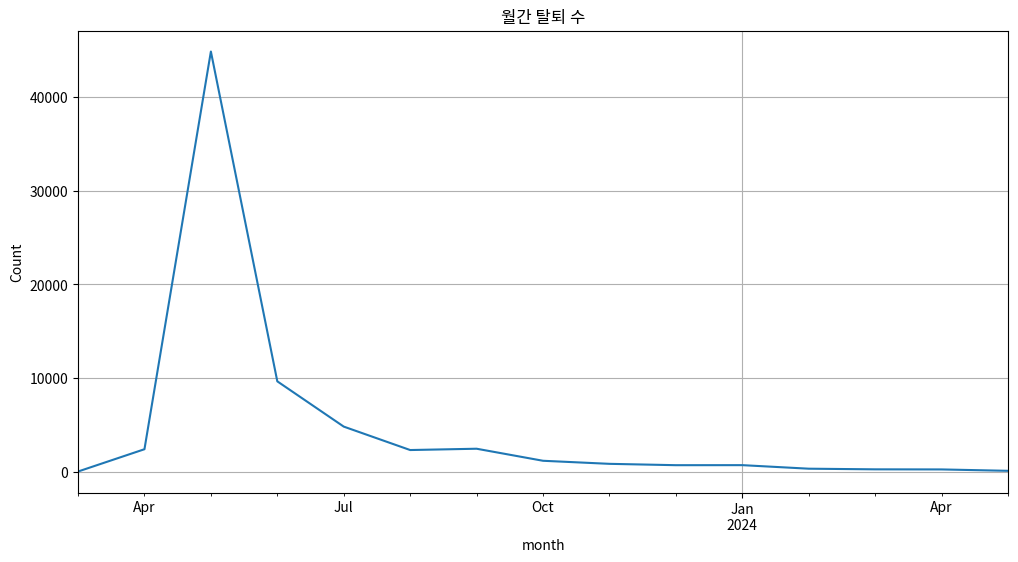

In [ ]:
# 일일 탈퇴 수
plt.figure(figsize=(12, 6))
daily_withdraw.plot()
plt.title('일일 탈퇴 수')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# 주간 탈퇴 수
plt.figure(figsize=(12, 6))
weekly_withdraw.plot()
plt.title('주간 탈퇴 수')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# 월간 탈퇴 수
plt.figure(figsize=(12, 6))
monthly_withdraw.plot()
plt.title('월간 탈퇴 수')
plt.ylabel('Count')
plt.grid(True)
plt.show()


### 시간별 가입자 수
- `user` 테이블에서 created_at 날짜별로 user 수 집계한 테이블 

In [ ]:
user_created = pd.read_csv('./data/user_created.csv', encoding = "utf-8")
user_created 

,date_only,user_count
0,2023-03-29,11
1,2023-03-31,22
2,2023-04-01,16
3,2023-04-02,1
4,2023-04-03,5
...,...,...
401,2024-05-05,13
402,2024-05-06,6
403,2024-05-07,3
404,2024-05-08,1


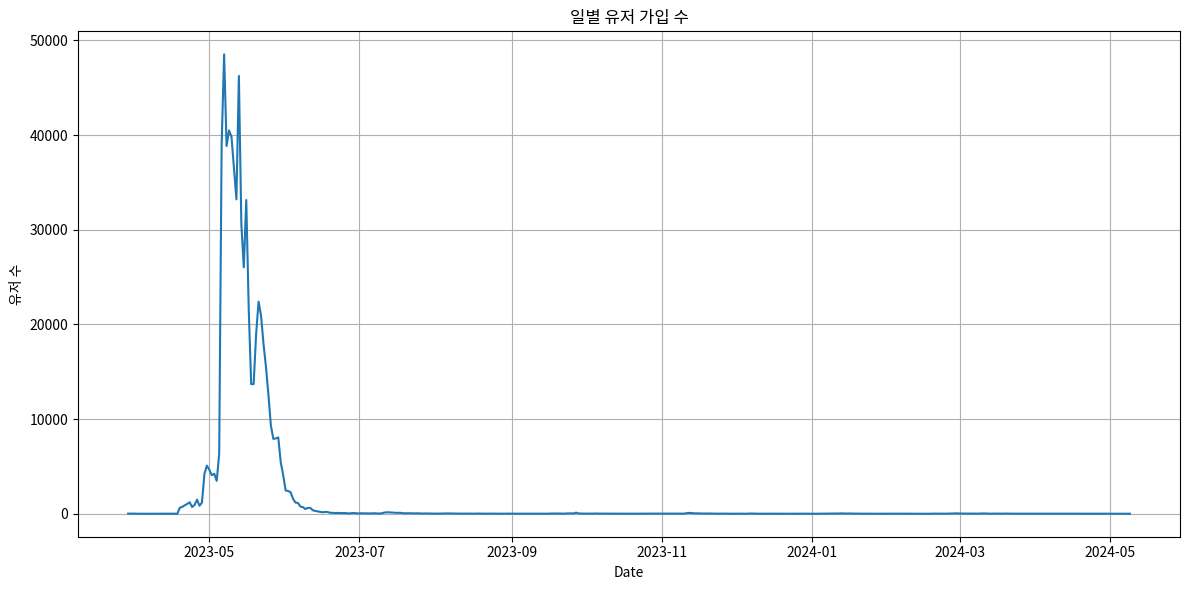

In [ ]:
# date_only 컬럼 datetime으로 변환 
user_created['date_only'] = pd.to_datetime(user_created['date_only'])

# 시각화 
plt.figure(figsize = (12,6))
plt.plot(user_created['date_only'], user_created['user_count'])
plt.title('일별 유저 가입 수')
plt.xlabel('Date')
plt.ylabel('유저 수')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 주별 집계하기 
user_created['week'] = user_created['date_only'].dt.to_period('W').apply(lambda r: r.start_time)

user_created_weekly = user_created.groupby('week')['user_count'].sum().reset_index()
user_created_weekly

,week,user_count
0,2023-03-27,50
1,2023-04-03,30
2,2023-04-10,27
3,2023-04-17,4518
4,2023-04-24,14468
5,2023-05-01,110341
6,2023-05-08,265824
7,2023-05-15,149564
8,2023-05-22,92182
9,2023-05-29,26313


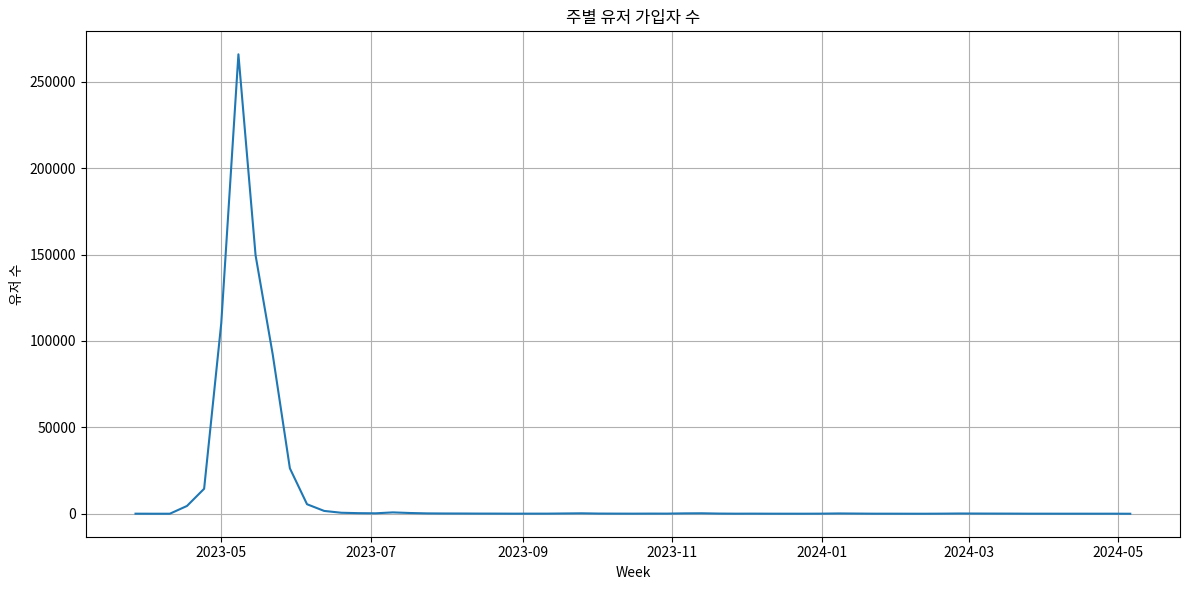

In [ ]:
# 주별 가입자 수 시각화
plt.figure(figsize=(12,6))
plt.plot(user_created_weekly['week'], user_created_weekly['user_count'])
plt.title('주별 유저 가입자 수')
plt.xlabel('Week')
plt.ylabel('유저 수')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 월별로 집계하기
user_created['month'] = user_created['date_only'].dt.to_period('M')

user_created_monthly = user_created.groupby('month')['user_count'].sum().reset_index()
user_created_monthly['month'] = user_created_monthly['month'].astype(str)
user_created_monthly

,month,user_count
0,2023-03,33
1,2023-04,19060
2,2023-05,635505
3,2023-06,16737
4,2023-07,1849
5,2023-08,524
6,2023-09,605
7,2023-10,409
8,2023-11,731
9,2023-12,231


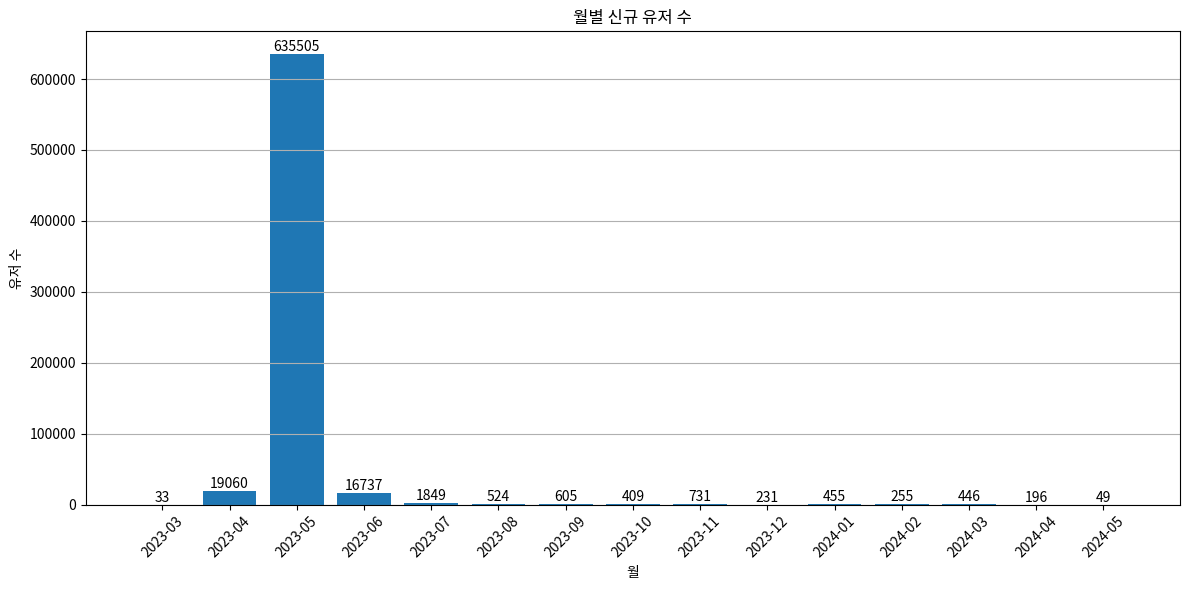

In [ ]:
# 월별 가입자 수 집계 시각화 
plt.figure(figsize=(12,6))

# 막대그래프
bars = plt.bar(user_created_monthly['month'], user_created_monthly['user_count'])

# x축 눈금: 매달 표시
plt.xticks(user_created_monthly['month'], rotation=45)

# 타이틀 및 축 레이블
plt.title('월별 신규 유저 수')
plt.xlabel('월')
plt.ylabel('유저 수')
plt.grid(axis='y')

# 막대 위에 수치 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, f'{int(height)}', 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# 투표 질문 수 조정하기

In [ ]:
user_question_record = pd.read_csv('./data/accounts_userquestionrecord.csv', encoding='utf-8')
user_question_record.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0


In [ ]:
user_question_record.duplicated(subset='question_id').sum()

1212753

In [ ]:
user_question_record.duplicated(subset='question_piece_id').sum()

0

- 투표자가 한 번 투표를 할 때 ***10개의 질문에 모두 투표했는지를*** 확인하고자 한다. 
- 불필요한 컬럼: 'status', 'chosen_id', 'has_read', 'answer_status', 'answer_updqted_at', 'report_count', 'opened_times'

In [ ]:
user_qr = user_question_record.drop(['status', 'chosen_user_id', 'has_read', 'answer_status', 'answer_updated_at', 'report_count', 'opened_times'], axis =1)
user_qr

,id,created_at,question_id,user_id,question_piece_id
0,771777,2023-04-28 12:27:49,252,849436,998458
1,771800,2023-04-28 12:28:02,244,849436,998459
2,771812,2023-04-28 12:28:09,183,849436,998460
3,771828,2023-04-28 12:28:16,101,849436,998461
4,771851,2023-04-28 12:28:26,209,849436,998462
...,...,...,...,...,...
1217553,161666166,2024-05-07 11:29:07,2614,1001607,190864020
1217554,161666461,2024-05-08 01:34:56,1679,855525,200139931
1217555,161666462,2024-05-08 01:35:02,2605,855525,200139932
1217556,161666463,2024-05-08 01:36:00,3801,855525,200139933


In [ ]:
# 데이터 타입 변환 
user_qr['created_at'] = pd.to_datetime(user_qr['created_at'])

# 투표 날짜만 따로 추출
user_qr['date'] = user_qr['created_at'].dt.date

user_qr

,id,created_at,question_id,user_id,question_piece_id,date
0,771777,2023-04-28 12:27:49,252,849436,998458,2023-04-28
1,771800,2023-04-28 12:28:02,244,849436,998459,2023-04-28
2,771812,2023-04-28 12:28:09,183,849436,998460,2023-04-28
3,771828,2023-04-28 12:28:16,101,849436,998461,2023-04-28
4,771851,2023-04-28 12:28:26,209,849436,998462,2023-04-28
...,...,...,...,...,...,...
1217553,161666166,2024-05-07 11:29:07,2614,1001607,190864020,2024-05-07
1217554,161666461,2024-05-08 01:34:56,1679,855525,200139931,2024-05-08
1217555,161666462,2024-05-08 01:35:02,2605,855525,200139932,2024-05-08
1217556,161666463,2024-05-08 01:36:00,3801,855525,200139933,2024-05-08


In [ ]:
# 정렬하기
user_qr.sort_values(by= ['date','user_id','created_at'], ascending=[True, True, True]).head(50)

,id,created_at,question_id,user_id,question_piece_id,date
903,787701,2023-04-28 14:18:07,161,838642,1023129,2023-04-28
905,787723,2023-04-28 14:18:16,286,838642,1023130,2023-04-28
908,787755,2023-04-28 14:18:29,203,838642,1023131,2023-04-28
910,787773,2023-04-28 14:18:36,265,838642,1023132,2023-04-28
912,787795,2023-04-28 14:18:45,307,838642,1023133,2023-04-28
913,787812,2023-04-28 14:18:54,149,838642,1023134,2023-04-28
915,787829,2023-04-28 14:19:00,191,838642,1023135,2023-04-28
917,787846,2023-04-28 14:19:08,237,838642,1023136,2023-04-28
919,787868,2023-04-28 14:19:21,202,838642,1023137,2023-04-28
6,771894,2023-04-28 12:28:46,247,847375,998689,2023-04-28


- 날짜 순, 유저 순, 시간 순으로 정렬하니 하나의 유저가 하루동안 참여한 모든 질문들이 순서대로 나와서 바로 세트 구분을 하기 어렵다. 
> 시간 간격을 계산해보자.
- 날짜 순으로 구분하면 자정 넘어갈 때 참여한 세트가 다른 세트로 분리되어 버린다. 
> 날짜 순으로는 먼저 구분할 필요 없을 듯 하고 유저 순, 시간 순으로만 구분한 다음 시간 간격으로 세트를 계산하는게 낫겠다. 

>> 그냥 polls_questionset에 set_id 있어서 머지하기로 했다. 제일 정확하다


In [ ]:
# date 컬럼 그냥 삭제하고, 유저 순, 시간 순으로 정렬하기
user_qr = user_qr.drop(['date'], axis=1)
user_qr = user_qr.sort_values(by= ['user_id', 'created_at'], ascending=[True, True])
user_qr.head(30)

,id,created_at,question_id,user_id,question_piece_id
12411,1010814,2023-04-29 16:22:56,121,838023,1167335
16684,1105460,2023-04-30 04:04:50,224,838023,1327698
16686,1105509,2023-04-30 04:05:01,121,838023,1327699
16687,1105536,2023-04-30 04:05:08,310,838023,1327700
16689,1105598,2023-04-30 04:05:22,203,838023,1327702
16701,1105877,2023-04-30 04:06:24,164,838023,1327703
16863,1109590,2023-04-30 04:18:56,144,838023,1327706
45401,1977214,2023-05-02 05:49:35,180,838023,1453455
63308,2580171,2023-05-03 08:35:26,524,838023,2574132
63328,2580439,2023-05-03 08:36:01,344,838023,2574143


In [ ]:
# polls_questionset 테이블 가져오기 
question_set = pd.read_csv('./data/polls_questionset.csv', encoding='utf-8')
question_set.head()

,id,question_piece_id_list,opening_time,status,created_at,user_id
0,99817,"[998458, 998459, 998460, 998461, 998462, 998463, 998464, 998465, 998466, 998467]",2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436
1,99830,"[998588, 998589, 998590, 998591, 998592, 998593, 998594, 998595, 998596, 998597]",2023-04-28 12:28:07,F,2023-04-28 12:28:07,849438
2,99840,"[998689, 998691, 998693, 998695, 998697, 998699, 998700, 998702, 998704, 998706]",2023-04-28 12:28:38,F,2023-04-28 12:28:38,847375
3,99841,"[998688, 998690, 998692, 998694, 998696, 998698, 998701, 998703, 998705, 998707]",2023-04-28 12:28:38,F,2023-04-28 12:28:38,849446
4,99848,"[998768, 998769, 998770, 998771, 998772, 998773, 998774, 998775, 998776, 998777]",2023-04-28 12:28:57,F,2023-04-28 12:28:57,849477


In [ ]:
question_set.groupby("id")["user_id"].nunique()

id
99817       1
99830       1
99840       1
99841       1
99848       1
           ..
20838253    1
20838344    1
20838419    1
20838445    1
20838446    1
Name: user_id, Length: 158384, dtype: int64

- 하나의 id(set_id)에는 한 명의 유저만 할당되었다. 

In [ ]:
# 컬럼명 변경하기 (id -> set_id)
question_set = question_set.rename(columns = {'id' : 'set_id'}) 

# question_piece_id_list 진짜 리스트로 형 변환하기
import ast  
question_set['question_piece_id_list'] = question_set['question_piece_id_list'].apply(ast.literal_eval)

# 리스트 정규화하기 
question_set_norm = question_set.explode('question_piece_id_list')
question_set_norm = question_set_norm.rename(columns = {'question_piece_id_list' : 'question_piece_id'})

# 불필요한 열 삭제하기 
question_set_norm = question_set_norm.drop(['created_at', 'opening_time'], axis=1)

question_set_norm.head()

,set_id,question_piece_id,status,user_id
0,99817,998458,F,849436
0,99817,998459,F,849436
0,99817,998460,F,849436
0,99817,998461,F,849436
0,99817,998462,F,849436


In [ ]:
len(question_set_norm)

1583840

In [ ]:
# user_id, question_piece_id를 기준으로 merge하기: user_qr에 set_id 추가하기
user_qr_set = pd.merge(user_qr, question_set_norm, how='left', on=['user_id','question_piece_id'])

# set_id가 없는 행 있는지 확인하기
user_qr_set['set_id'].isna().sum()

0

In [ ]:
user_qr_set

,id,created_at,question_id,user_id,question_piece_id,set_id,status
0,1010814,2023-04-29 16:22:56,121,838023,1167335,116704,F
1,1105460,2023-04-30 04:04:50,224,838023,1327698,132741,F
2,1105509,2023-04-30 04:05:01,121,838023,1327699,132741,F
3,1105536,2023-04-30 04:05:08,310,838023,1327700,132741,F
4,1105598,2023-04-30 04:05:22,203,838023,1327702,132741,F
...,...,...,...,...,...,...,...
1217553,160418395,2023-08-05 13:19:15,3264,1579418,206172529,20617176,F
1217554,161100138,2023-09-20 15:31:20,1487,1580578,207530981,20753022,O
1217555,161100139,2023-09-20 15:31:38,3807,1580578,207530984,20753022,O
1217556,161643072,2024-03-19 12:56:39,4975,1583358,208351463,20835070,F


In [ ]:
# set_id 별로 몇 개의 행이 있는지 확인하기 : set_id 당 몇 개의 question_piece_id가 있는지 확인하기
    # 한 세트 내에서 투표한 질문 수 = question_cnt 컬럼
user_qr_cnt = user_qr_set.groupby(['set_id','user_id'])['question_piece_id'].nunique().reset_index(name='question_cnt').sort_values(by='question_cnt', ascending=False)
user_qr_cnt

,set_id,user_id,question_cnt
0,99817,849436,10
52261,3954737,1101088,10
115586,12094100,1170559,10
52315,3960625,1158106,10
52317,3960857,1113966,10
...,...,...,...
141834,17326660,1171866,1
141831,17324017,935887,1
141818,17322185,881242,1
129914,14745134,1381784,1


In [ ]:
# 인덱스 초기화하기 : 보기 좋게 하기 위해서
user_qr_cnt = user_qr_cnt.reset_index(drop=True)
user_qr_cnt

,set_id,user_id,question_cnt
0,99817,849436,10
1,3954737,1101088,10
2,12094100,1170559,10
3,3960625,1158106,10
4,3960857,1113966,10
...,...,...,...
152220,17326660,1171866,1
152221,17324017,935887,1
152222,17322185,881242,1
152223,14745134,1381784,1


In [ ]:
user_qr_cnt['question_cnt'].describe()


count    152225.000000
mean          7.998410
std           2.262638
min           1.000000
25%           7.000000
50%           9.000000
75%          10.000000
max          10.000000
Name: question_cnt, dtype: float64

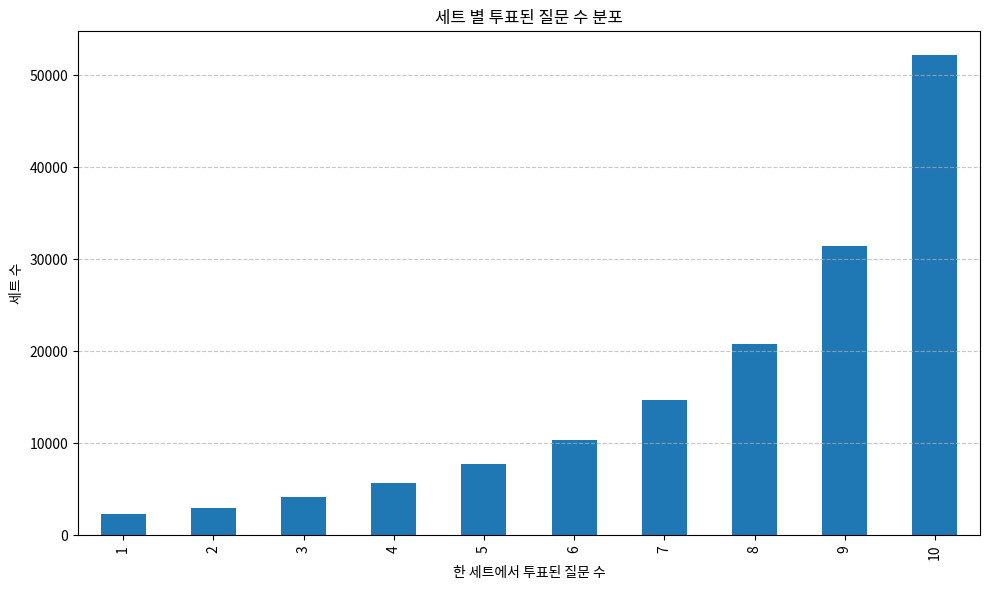

In [ ]:
# question_cnt 별로 set_id 개수 확인하기
count_dist = user_qr_cnt['question_cnt'].value_counts().sort_index()

# 시각화
plt.figure(figsize=(10, 6))
count_dist.plot(kind='bar')

plt.xlabel("한 세트에서 투표된 질문 수")
plt.ylabel("세트 수")
plt.title("세트 별 투표된 질문 수 분포")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [ ]:
# 비율로 확인하기
count_pct = user_qr_cnt['question_cnt'].value_counts(normalize=True).sort_index() * 100
count_pct

question_cnt
1      1.491871
2      1.947118
3      2.753818
4      3.708326
5      5.117425
6      6.802431
7      9.626540
8     13.663327
9     20.625390
10    34.263754
Name: proportion, dtype: float64

In [ ]:
# 빈도와 비율 한 번에 보기 
count_summary = pd.DataFrame({
    "set_count": user_qr_cnt['question_cnt'].value_counts().sort_index(),
    "percentage": count_pct
})

count_summary

,set_count,percentage
question_cnt,,
1,2271,1.491871
2,2964,1.947118
3,4192,2.753818
4,5645,3.708326
5,7790,5.117425
6,10355,6.802431
7,14654,9.626540
8,20799,13.663327
9,31397,20.625390


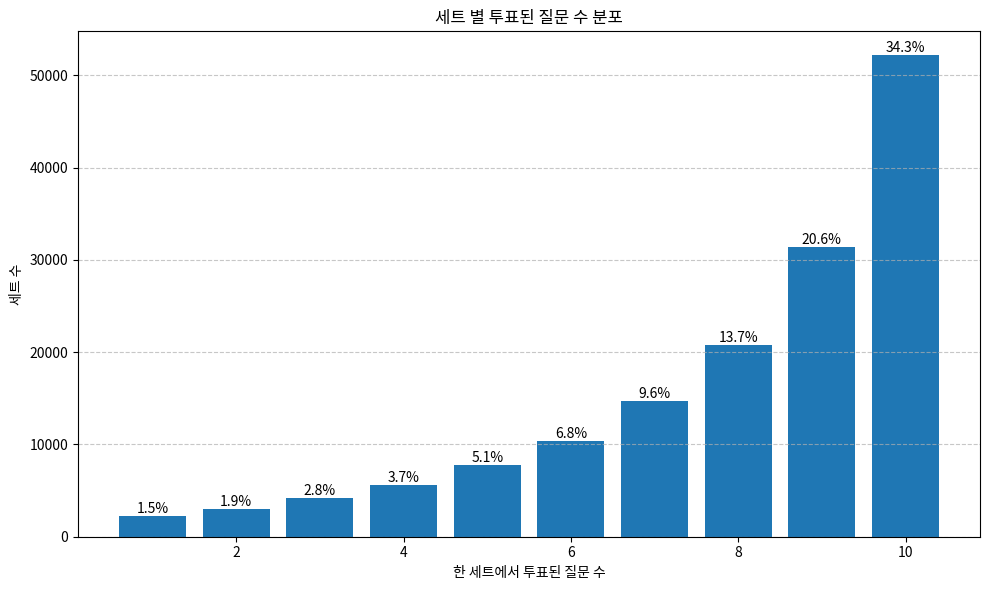

In [ ]:
# 시각화 
plt.figure(figsize=(10, 6))
bars = plt.bar(count_summary.index, count_summary["set_count"])

# 막대 위에 퍼센트 라벨 붙이기
for bar, pct in zip(bars, count_summary["percentage"]):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{pct:.1f}%',  # 소수점 1자리 퍼센트
             ha='center', va='bottom', fontsize=10)

plt.xlabel("한 세트에서 투표된 질문 수")
plt.ylabel("세트 수")
plt.title("세트 별 투표된 질문 수 분포")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


투표 간격을 살펴볼 필요가 있을 듯. 

In [ ]:
# created_at 컬럼을 datetime으로 변환하기
user_qr_set['created_at'] = pd.to_datetime(user_qr_set['created_at'])

# set_id 별로 시간 정렬 후 시간 간격 계산하기: 하나의 세트 내에서 투표 간격 계산하기 
user_qr_set = user_qr_set.sort_values(by=["set_id", "created_at"])
user_qr_set["time_diff"] = user_qr_set.groupby("set_id")["created_at"].diff()

user_qr_set.head(30)

,id,created_at,question_id,user_id,question_piece_id,set_id,status,time_diff
7257,771777,2023-04-28 12:27:49,252,849436,998458,99817,F,NaT
7258,771800,2023-04-28 12:28:02,244,849436,998459,99817,F,0 days 00:00:13
7259,771812,2023-04-28 12:28:09,183,849436,998460,99817,F,0 days 00:00:07
7260,771828,2023-04-28 12:28:16,101,849436,998461,99817,F,0 days 00:00:07
7261,771851,2023-04-28 12:28:26,209,849436,998462,99817,F,0 days 00:00:10
7262,771864,2023-04-28 12:28:32,239,849436,998463,99817,F,0 days 00:00:06
7263,771908,2023-04-28 12:28:55,146,849436,998464,99817,F,0 days 00:00:23
7264,771940,2023-04-28 12:29:13,297,849436,998465,99817,F,0 days 00:00:18
7265,771952,2023-04-28 12:29:21,294,849436,998466,99817,F,0 days 00:00:08
7266,771974,2023-04-28 12:29:33,201,849436,998467,99817,F,0 days 00:00:12


In [ ]:
user_qr_set.describe()



,id,created_at,question_id,user_id,set_id,time_diff
count,1.217558e+06,1217558,1.217558e+06,1.217558e+06,1.217558e+06,1065333
mean,5.957298e+07,2023-05-17 12:51:25.947101696,6.843895e+02,1.105790e+06,7.413177e+06,0 days 00:21:32.905700846
min,7.717770e+05,2023-04-28 12:27:49,9.900000e+01,8.380230e+05,9.981700e+04,0 days 00:00:00
25%,1.553965e+07,2023-05-10 01:42:11,2.750000e+02,8.846190e+05,1.854114e+06,0 days 00:00:07
50%,5.302680e+07,2023-05-15 15:43:01.500000,4.690000e+02,1.117537e+06,6.616813e+06,0 days 00:00:09
75%,9.480960e+07,2023-05-22 11:01:03.750000128,9.420000e+02,1.259186e+06,1.176732e+07,0 days 00:00:14
max,1.616665e+08,2024-05-08 01:36:18,5.133000e+03,1.583358e+06,2.083507e+07,282 days 06:25:30
std,4.608193e+07,NaN,6.250399e+02,2.062704e+05,5.757227e+06,0 days 21:51:47.605508827


### 각종 보조지표 추출하기 
DAU, D1 리텐션율, 평균 응답 갯수, 반복 세트 참여율


In [ ]:
user_qr_set.head()

,id,created_at,question_id,user_id,question_piece_id,set_id,status,time_diff
7257,771777,2023-04-28 12:27:49,252,849436,998458,99817,F,NaT
7258,771800,2023-04-28 12:28:02,244,849436,998459,99817,F,0 days 00:00:13
7259,771812,2023-04-28 12:28:09,183,849436,998460,99817,F,0 days 00:00:07
7260,771828,2023-04-28 12:28:16,101,849436,998461,99817,F,0 days 00:00:07
7261,771851,2023-04-28 12:28:26,209,849436,998462,99817,F,0 days 00:00:10


In [ ]:
# DAU 계산하기 : 일자별 고유 유저 수
## 투표 날짜 컬럼 'date' 추가하기 
user_qr_set['date'] = user_qr_set['created_at'].dt.normalize()
## DAU 계산하기
user_qr_set.groupby('date')['user_id'].nunique().reset_index(name='DAU')

# 사실 하진님 데이터 참고하면 된다 

,date,DAU
0,2023-04-28,125
1,2023-04-29,221
2,2023-04-30,325
3,2023-05-01,325
4,2023-05-02,413
...,...,...
268,2024-05-03,1
269,2024-05-05,1
270,2024-05-06,1
271,2024-05-07,2


In [ ]:
# D1 리텐션율을 세트별로 계산하기
# 유저별 참여 날짜 리스트 정리
user_days = user_qr_set.groupby('user_id')['date'].apply(lambda x: sorted(set(x))).reset_index()

# D1 리텐션 여부 계산 함수
def has_d1(days):
    if len(days) < 2:
        return False
    return (pd.to_datetime(days[1]) - pd.to_datetime(days[0])).days == 1

user_days['d1_retained'] = user_days['date'].apply(has_d1)

# 전체 평균
d1_retention_rate = user_days['d1_retained'].mean()
print(f"D1 리텐션율: {d1_retention_rate:.2%}")

D1 리텐션율: 90.76%


In [ ]:
# 평균 응답 개수
mean_cnt = user_qr_cnt['question_cnt'].mean()
print(f"평균 응답 개수: {mean_cnt:.2f}")


평균 응답 개수: 8.00


In [ ]:
# 반복 세트 참여율 계산하기         
set_counts = user_qr_set.groupby('user_id')['set_id'].nunique()
repeat_participation_rate = (set_counts > 1).mean()
print(f"반복 세트 참여율: {repeat_participation_rate:.2%}")


반복 세트 참여율: 97.26%


- 서비스 초창기에는 가입자, 활동자 수가 많고 두세달 뒤 급락하는 양상이었기 때문에 단순한 D1 리텐션율, DAU, 반복 세트 참여율 보다는 `코호트 분석`을 활용해야 서비스의 지속성을 과대평가하지 않을 수 있다. 
- 최근 코호트(1,2달에 유입된 유저)는 아직 다음 달 활동 여부를 알 수 없으므로 제외하거나 보조로 표시해야 한다. 
- 따라서 A/B 테스트 역시 최근 유입된 유저들을 기준으로 지표 변화를 살펴야 한다. 

In [ ]:
user_qr_set.head()

,id,created_at,question_id,user_id,question_piece_id,set_id,status,time_diff,date
7257,771777,2023-04-28 12:27:49,252,849436,998458,99817,F,NaT,2023-04-28
7258,771800,2023-04-28 12:28:02,244,849436,998459,99817,F,0 days 00:00:13,2023-04-28
7259,771812,2023-04-28 12:28:09,183,849436,998460,99817,F,0 days 00:00:07,2023-04-28
7260,771828,2023-04-28 12:28:16,101,849436,998461,99817,F,0 days 00:00:07,2023-04-28
7261,771851,2023-04-28 12:28:26,209,849436,998462,99817,F,0 days 00:00:10,2023-04-28


### 유저별로 매일 참여한 세트 갯수 몇 갠지 집계해보자

In [ ]:
# 유저별, 날짜별, 세트별로 중복 제거
unique_sets = user_qr_set[['user_id', 'date', 'set_id']].drop_duplicates()

# 유저별 날짜별 참여 세트 수 집계
user_daily_set_cnt = unique_sets.groupby(['user_id', 'date'])['set_id'].count().reset_index(name='set_cnt')

# 결과 확인
user_daily_set_cnt

,user_id,date,set_cnt
0,838023,2023-04-29,1
1,838023,2023-04-30,1
2,838023,2023-05-02,1
3,838023,2023-05-03,2
4,838023,2023-05-04,1
...,...,...,...
50969,1579418,2023-07-29,1
50970,1579418,2023-07-30,1
50971,1579418,2023-08-05,1
50972,1580578,2023-09-20,1


In [ ]:
# 유저별 하루 평균 세트 참여 수 계산
user_avg_set_per_day = user_daily_set_cnt.groupby('user_id')['set_cnt'].mean().reset_index(name='avg_set_per_day')

# 결과 확인
user_avg_set_per_day

,user_id,avg_set_per_day
0,838023,1.200000
1,838466,2.625000
2,838642,1.000000
3,839357,3.444444
4,840293,2.714286
...,...,...
4844,1577440,1.625000
4845,1578095,1.000000
4846,1579418,1.166667
4847,1580578,1.000000


In [ ]:
user_avg_set_per_day.describe()
# 평균적으로 하루에 2.9 세트에 참여함. 

,user_id,avg_set_per_day
count,4.849000e+03,4849.000000
mean,1.109473e+06,2.949499
std,2.160293e+05,1.494945
min,8.380230e+05,1.000000
25%,8.851120e+05,1.884615
50%,1.116196e+06,2.647059
75%,1.275457e+06,3.687500
max,1.583358e+06,14.090909


유저별 고유 활동 날짜 수 계산하기 

In [ ]:
# 유저별 고유 활동 날짜 수 계산
user_active_days = user_qr_set.groupby("user_id")["date"].nunique().reset_index()

# 컬럼 이름 정리
user_active_days.columns = ["user_id", "active_days"]

# 결과 확인
user_active_days

,user_id,active_days
0,838023,5
1,838466,8
2,838642,2
3,839357,9
4,840293,7
...,...,...
4844,1577440,8
4845,1578095,4
4846,1579418,6
4847,1580578,1


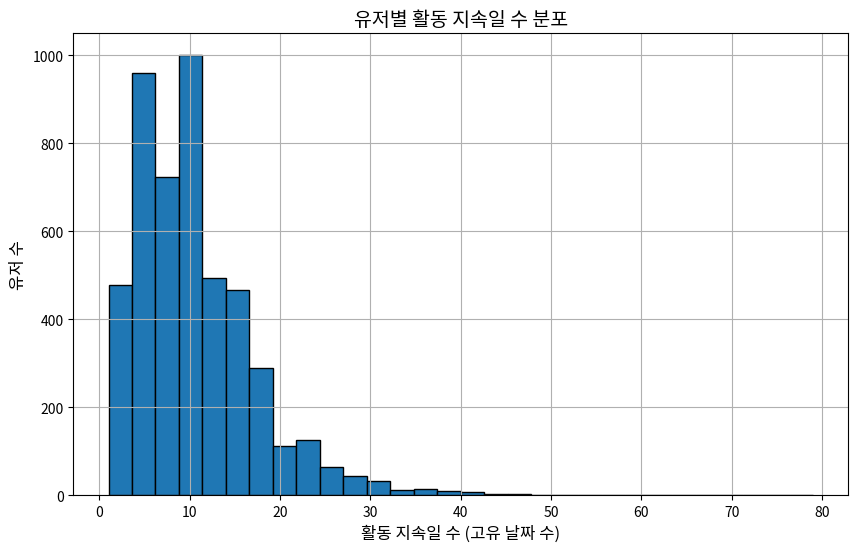

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(user_active_days["active_days"], bins=30, edgecolor='black')
plt.title("유저별 활동 지속일 수 분포", fontsize=14)
plt.xlabel("활동 지속일 수 (고유 날짜 수)", fontsize=12)
plt.ylabel("유저 수", fontsize=12)
plt.grid(True)
plt.show()

### 코호트 분석: 리텐션과 반복 참여율 분석하기, 평균 응답갯수

In [ ]:
user_qr_set

,id,created_at,question_id,user_id,question_piece_id,set_id,status,time_diff,date
7257,771777,2023-04-28 12:27:49,252,849436,998458,99817,F,NaT,2023-04-28
7258,771800,2023-04-28 12:28:02,244,849436,998459,99817,F,0 days 00:00:13,2023-04-28
7259,771812,2023-04-28 12:28:09,183,849436,998460,99817,F,0 days 00:00:07,2023-04-28
7260,771828,2023-04-28 12:28:16,101,849436,998461,99817,F,0 days 00:00:07,2023-04-28
7261,771851,2023-04-28 12:28:26,209,849436,998462,99817,F,0 days 00:00:10,2023-04-28
...,...,...,...,...,...,...,...,...,...
865901,161639783,2024-03-10 03:29:12,2049,1227249,208345628,20834486,F,0 days 00:00:12,2024-03-10
865902,161639784,2024-03-10 03:29:20,832,1227249,208345629,20834486,F,0 days 00:00:08,2024-03-10
865903,161639785,2024-03-10 03:30:47,1119,1227249,208345630,20834486,F,0 days 00:01:27,2024-03-10
1217556,161643072,2024-03-19 12:56:39,4975,1583358,208351463,20835070,F,NaT,2024-03-19


In [ ]:
# created_at 기준 유저별 첫 참여 달: 코호트 정의
first_day = user_qr_set.groupby('user_id')['created_at'].min().reset_index()
first_day['cohort_month'] = first_day['created_at'].dt.to_period('M')

# 첫 참여 일도 포함하자 
first_day['first_date'] = first_day['created_at'].dt.normalize()

first_day.head()

,user_id,created_at,cohort_month,first_date
0,838023,2023-04-29 16:22:56,2023-04,2023-04-29
1,838466,2023-05-02 22:42:05,2023-05,2023-05-02
2,838642,2023-04-28 14:18:07,2023-04,2023-04-28
3,839357,2023-04-29 16:51:01,2023-04,2023-04-29
4,840293,2023-05-03 02:24:05,2023-05,2023-05-03


In [ ]:
# user_qr_set에 코호트 정보 추가하기 
user_qr_set = pd.merge(user_qr_set, first_day[['user_id', 'cohort_month', 'first_date']], on='user_id', how='left')
user_qr_set['event_month'] = user_qr_set['created_at'].dt.to_period('M') # 활동 월 추가

user_qr_set.head()

,id,created_at,question_id,user_id,question_piece_id,set_id,status,time_diff,date,cohort_month,first_date,event_month
0,771777,2023-04-28 12:27:49,252,849436,998458,99817,F,NaT,2023-04-28,2023-04,2023-04-28,2023-04
1,771800,2023-04-28 12:28:02,244,849436,998459,99817,F,0 days 00:00:13,2023-04-28,2023-04,2023-04-28,2023-04
2,771812,2023-04-28 12:28:09,183,849436,998460,99817,F,0 days 00:00:07,2023-04-28,2023-04,2023-04-28,2023-04
3,771828,2023-04-28 12:28:16,101,849436,998461,99817,F,0 days 00:00:07,2023-04-28,2023-04,2023-04-28,2023-04
4,771851,2023-04-28 12:28:26,209,849436,998462,99817,F,0 days 00:00:10,2023-04-28,2023-04,2023-04-28,2023-04


In [ ]:
# 리텐션 플래그(D1, D3, D7) 계산하기 
## 날짜 차이 계산 
user_qr_set['days_since_first'] = (user_qr_set['date'] - user_qr_set['first_date']).dt.days

# 리텐션 플래그
retention_flags = user_qr_set.groupby('user_id')['days_since_first'].agg(set).reset_index()

retention_flags['d1'] = retention_flags['days_since_first'].apply(lambda x: any(day == 1 for day in x))
retention_flags['d3'] = retention_flags['days_since_first'].apply(lambda x: any(1 <= day <= 3 for day in x))
retention_flags['d7'] = retention_flags['days_since_first'].apply(lambda x: any(1 <= day <= 7 for day in x))

In [ ]:
# 반복 참여 플래그 
set_count = user_qr_set.groupby('user_id')['set_id'].nunique().reset_index(name='set_count')
retention_flags = retention_flags.merge(set_count, on='user_id')
retention_flags['repeat'] = retention_flags['set_count'] > 1

retention_flags.head()

,user_id,days_since_first,d1,d3,d7,set_count,repeat
0,838023,"{0, 1, 3, 4, 5}",True,True,True,6,True
1,838466,"{0, 1, 2, 3, 4, 5, 139, 31}",True,True,True,21,True
2,838642,"{0, 1}",True,True,True,2,True
3,839357,"{0, 1, 2, 3, 4, 5, 7, 8, 27}",True,True,True,29,True
4,840293,"{0, 1, 2, 3, 4, 8, 12}",True,True,True,19,True


In [ ]:
# cohort_month 정보 붙이기
cohorts = user_qr_set[['user_id', 'cohort_month']].drop_duplicates()
retention_flags = retention_flags.merge(cohorts, on='user_id')

# 코호트별 비율 계산
cohort_metrics = retention_flags.groupby('cohort_month').agg(
    d1_retention=('d1', 'mean'),
    d3_retention=('d3', 'mean'),
    d7_retention=('d7', 'mean'),
    repeat_rate=('repeat', 'mean'),
    user_count=('user_id', 'count')
).reset_index()

print(cohort_metrics)

  cohort_month  d1_retention  d3_retention  d7_retention  repeat_rate  \
0      2023-04      0.955621      0.982249      0.988166     0.994083   
1      2023-05      0.908481      0.954800      0.962855     0.973596   
2      2023-06      0.500000      0.588235      0.617647     0.764706   
3      2023-07      0.250000      0.250000      0.250000     0.500000   
4      2023-08      0.000000      0.000000      0.000000     0.500000   
5      2023-09      0.000000      0.000000      0.000000     0.000000   
6      2024-03      0.000000      0.000000      0.000000     0.000000   

   user_count  
0         338  
1        4469  
2          34  
3           4  
4           2  
5           1  
6           1  


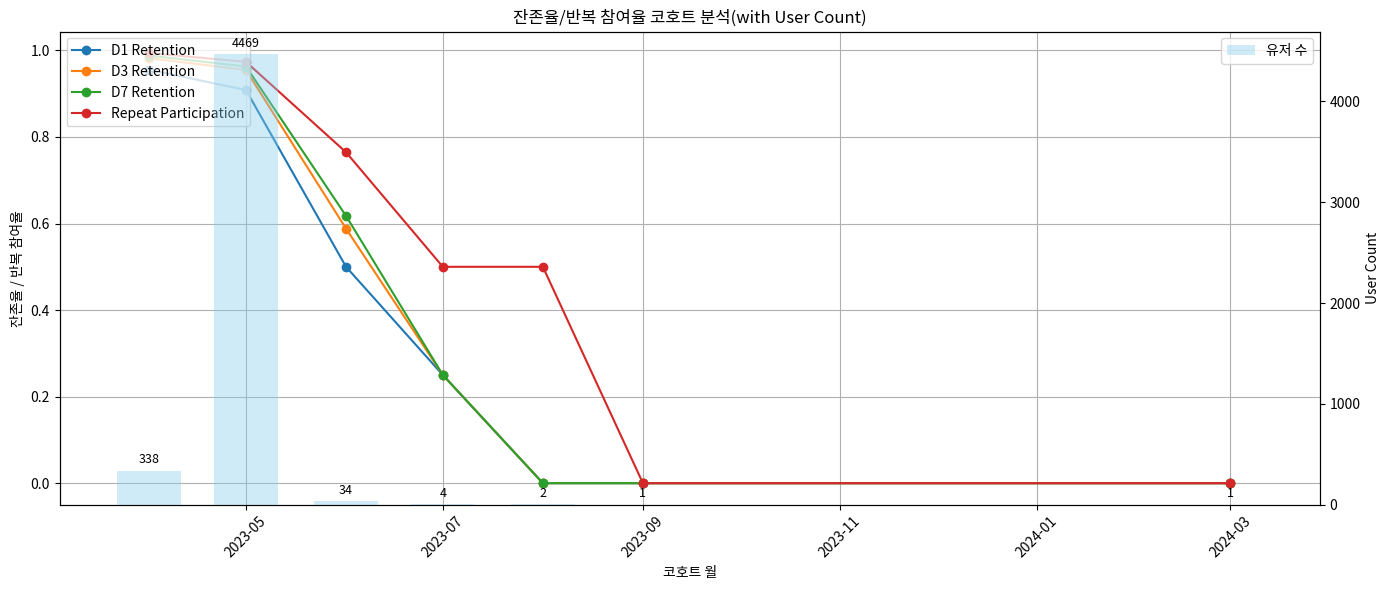

In [ ]:
# Period → Timestamp (필수 변환)
cohort_metrics['cohort_month'] = cohort_metrics['cohort_month'].dt.to_timestamp()

# 시각화 시작
fig, ax1 = plt.subplots(figsize=(14, 6))

# 선 그래프: 리텐션 및 반복 참여율
ax1.plot(cohort_metrics['cohort_month'], cohort_metrics['d1_retention'], marker='o', label='D1 Retention')
ax1.plot(cohort_metrics['cohort_month'], cohort_metrics['d3_retention'], marker='o', label='D3 Retention')
ax1.plot(cohort_metrics['cohort_month'], cohort_metrics['d7_retention'], marker='o', label='D7 Retention')
ax1.plot(cohort_metrics['cohort_month'], cohort_metrics['repeat_rate'], marker='o', label='Repeat Participation')

ax1.set_xlabel('코호트 월')
ax1.set_ylabel('잔존율 / 반복 참여율')
ax1.set_title('잔존율/반복 참여율 코호트 분석(with User Count)')
ax1.legend(loc='upper left')
ax1.grid(True)
ax1.tick_params(axis='x', rotation=45)

# 보조축: 막대 그래프 (유저 수)
ax2 = ax1.twinx()
bars = ax2.bar(
    cohort_metrics['cohort_month'],
    cohort_metrics['user_count'],
    width=20,
    color='skyblue',
    alpha=0.4,
    label='유저 수'
)
ax2.set_ylabel('User Count')
ax2.legend(loc='upper right')

# 막대 위에 숫자 표시
for bar in bars:
    height = bar.get_height()
    ax2.annotate(
        f'{int(height)}',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),  # 약간 위로 띄우기
        textcoords='offset points',
        ha='center', va='bottom',
        fontsize=9, color='black'
    )

plt.tight_layout()
plt.show()


In [ ]:
## 장기 활동 지표 요약
# 1. datetime 처리 및 첫 방문일 계산
user_qr_set['month_since_first'] = (
    user_qr_set['created_at'].dt.to_period('M') - user_qr_set['first_date'].dt.to_period('M')
).apply(lambda x: x.n)

# 2. 장기 재방문 여부 (30일 이후 한 번이라도 참여했는지)
revisit_30plus = user_qr_set.groupby('user_id')['days_since_first'].apply(lambda x: any(x >= 60))
revisit_30plus.name = 'revisited_30plus'

# 3. 활동한 고유 개월 수
month_active = user_qr_set.groupby('user_id')['month_since_first'].apply(set).reset_index()
month_active['active_months'] = month_active['month_since_first'].apply(len)
month_active = month_active[['user_id', 'active_months']]

# 4. 세트 간 평균 응답 간격
user_qr_set = user_qr_set.sort_values(['user_id', 'created_at'])
user_qr_set['prev_time'] = user_qr_set.groupby('user_id')['created_at'].shift(1)
user_qr_set['gap_days'] = (user_qr_set['created_at'] - user_qr_set['prev_time']).dt.days
avg_gap_by_user = user_qr_set.groupby('user_id')['gap_days'].mean().reset_index(name='avg_gap_days')

# 5. 고유 참여 일수
active_days = user_qr_set.groupby('user_id')['created_at'].nunique().reset_index(name='active_days')

# 6. 통합 정리
summary = pd.DataFrame({'user_id': user_qr_set['user_id'].unique()})
summary = summary.merge(revisit_30plus, on='user_id')
summary = summary.merge(month_active, on='user_id')
summary = summary.merge(avg_gap_by_user, on='user_id')
summary = summary.merge(active_days, on='user_id')

# 7. 전체 요약 통계
long_term_revisit_rate = summary['revisited_30plus'].mean()
active_3mo_rate = (summary['active_months'] >= 3).mean()

print("✅ 장기 재방문율 (30일 이후 재참여): {:.2%}".format(long_term_revisit_rate))
print("✅ 3개월 이상 활동 유지율: {:.2%}".format(active_3mo_rate))

# summary는 사용자별 장기 활동 지표 요약 테이블


✅ 장기 재방문율 (30일 이후 재참여): 11.76%
✅ 3개월 이상 활동 유지율: 11.16%


In [ ]:
summary.head()


,user_id,revisited_30plus,active_months,avg_gap_days,active_days
0,838023,False,2,0.142857,22
1,838466,True,3,1.030769,131
2,838642,False,1,0.000000,10
3,839357,False,2,0.094787,212
4,840293,False,1,0.047337,170


## Kaplan-Meier, Cox 회귀 분석

In [ ]:
# 생존 분석용 데이터
# 유저별 최초, 최종 활동일 계산 
user_lifespan = user_qr_set.groupby('user_id').agg(
    first_date=('created_at', 'min'),
    last_date=('created_at', 'max')
).reset_index()

# 유저별 활동 기간 계산
user_lifespan['duration_days'] = (user_lifespan['last_date'] - user_lifespan['first_date']).dt.days

# 이벤트(이탈) 발생 여부 설정 (이탈 여부 판단 기준: 관측 종료일 이전에 마지막 활동했으면 True)
cutoff_date = user_qr_set['created_at'].max()
user_lifespan['event_observed'] = user_lifespan['last_date'] < cutoff_date

# 생존 분석용 테이블 완성
survival_df = user_lifespan[['user_id', 'duration_days', 'event_observed']]

survival_df.head()

,user_id,duration_days,event_observed
0,838023,4,True
1,838466,138,True
2,838642,0,True
3,839357,26,True
4,840293,12,True


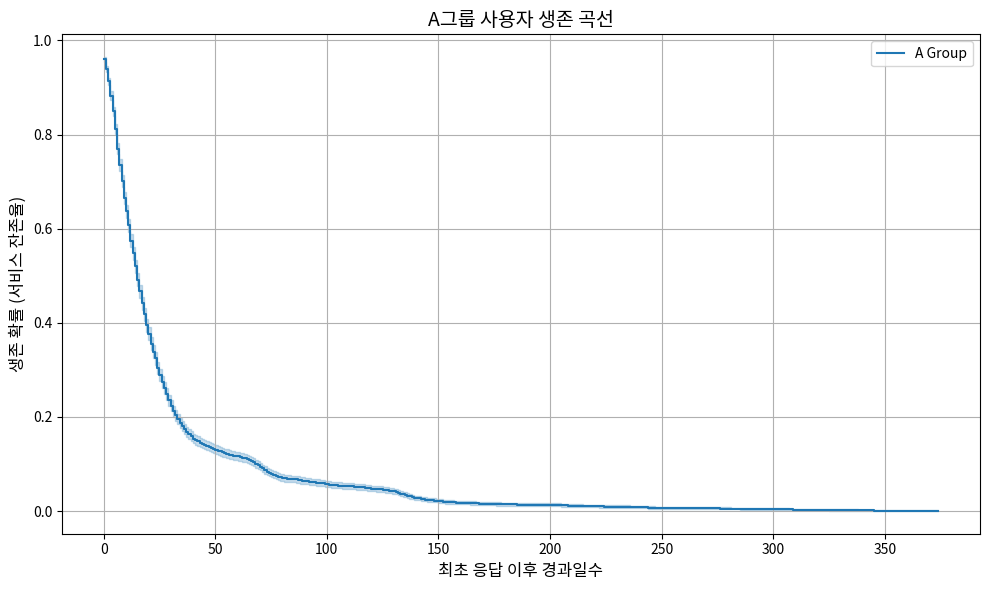

In [ ]:
from lifelines import KaplanMeierFitter

T = survival_df['duration_days']
E = survival_df['event_observed']

kmf = KaplanMeierFitter()
kmf.fit(durations=T, event_observed=E, label='A Group')

plt.figure(figsize=(10, 6))
kmf.plot(ci_show=True)
plt.title('A그룹 사용자 생존 곡선', fontsize=14)
plt.xlabel('최초 응답 이후 경과일수', fontsize=12)
plt.ylabel('생존 확률 (서비스 잔존율)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

### 응답한 질문 수가 적을 수록 생존 기간이 짧은지

In [ ]:
user_qr_cnt

,set_id,user_id,question_cnt
0,99817,849436,10
1,3954737,1101088,10
2,12094100,1170559,10
3,3960625,1158106,10
4,3960857,1113966,10
...,...,...,...
152220,17326660,1171866,1
152221,17324017,935887,1
152222,17322185,881242,1
152223,14745134,1381784,1


In [ ]:
user_lifespan

,user_id,first_date,last_date,duration_days,event_observed
0,838023,2023-04-29 16:22:56,2023-05-04 07:26:25,4,True
1,838466,2023-05-02 22:42:05,2023-09-18 12:48:28,138,True
2,838642,2023-04-28 14:18:07,2023-04-29 03:00:56,0,True
3,839357,2023-04-29 16:51:01,2023-05-26 07:18:10,26,True
4,840293,2023-05-03 02:24:05,2023-05-15 09:35:08,12,True
...,...,...,...,...,...
4844,1577440,2023-06-29 09:03:48,2023-09-18 15:23:58,81,True
4845,1578095,2023-07-11 13:29:13,2023-12-08 14:35:49,150,True
4846,1579418,2023-07-25 13:48:30,2023-08-05 13:19:15,10,True
4847,1580578,2023-09-20 15:31:20,2023-09-20 15:31:38,0,True


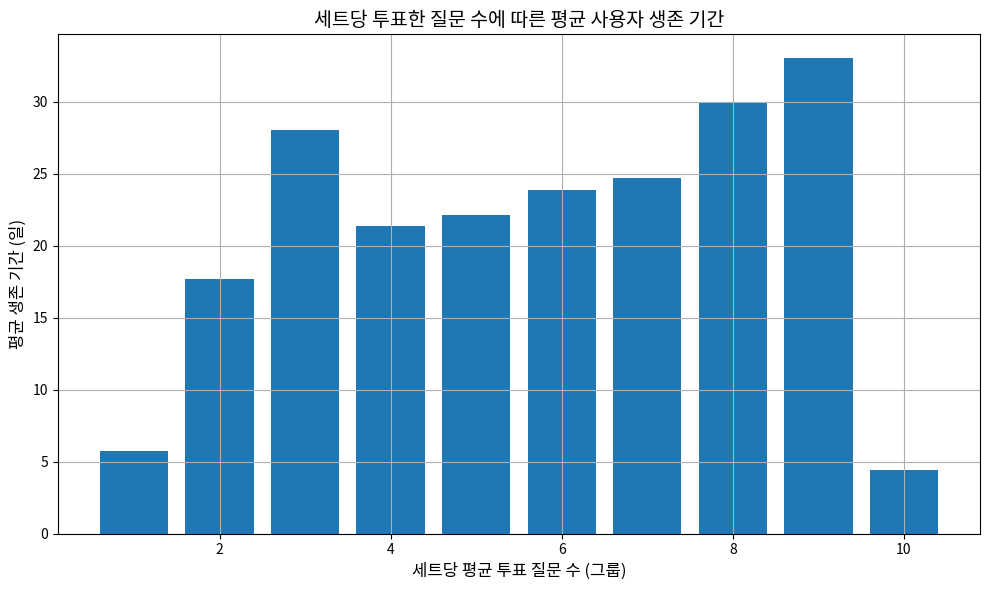

In [ ]:
# 1. user_qr_cnt에서 사용자별 평균 question_cnt 계산
user_mean_qcnt = user_qr_cnt.groupby('user_id')['question_cnt'].mean().reset_index(name='mean_question_cnt')

# 2. user_lifespan과 병합
summary_df = pd.merge(user_lifespan[['user_id', 'duration_days']], user_mean_qcnt, on='user_id', how='inner')

# 3. question_cnt를 정수로 내림 (그룹화용)
summary_df['qcnt_group'] = summary_df['mean_question_cnt'].astype(int)

# 4. 그룹별 평균 생존 기간 계산
grouped = summary_df.groupby('qcnt_group')['duration_days'].mean().reset_index()

# 5. 시각화
plt.figure(figsize=(10, 6))
plt.bar(grouped['qcnt_group'], grouped['duration_days'])
plt.xlabel('세트당 평균 투표 질문 수 (그룹)', fontsize=12)
plt.ylabel('평균 생존 기간 (일)', fontsize=12)
plt.title('세트당 투표한 질문 수에 따른 평균 사용자 생존 기간', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


- 근데 이건 유저 구분이 안되었다. 

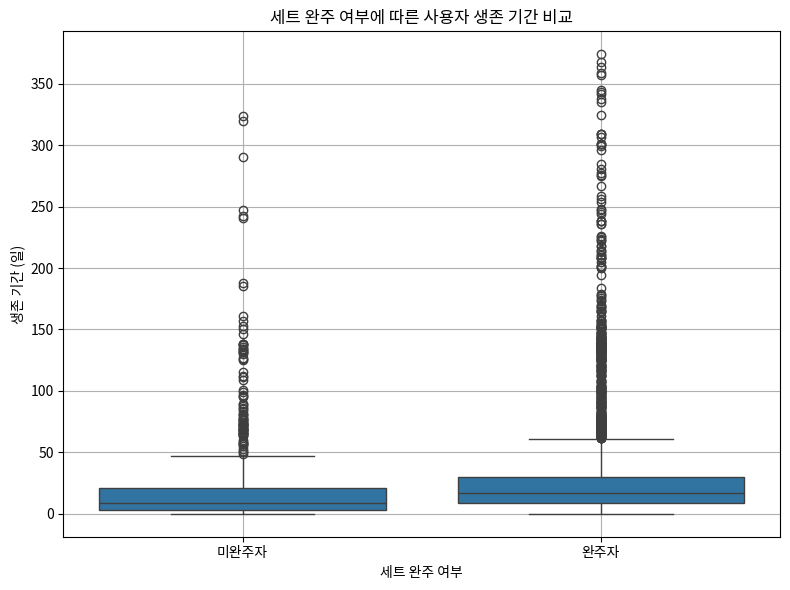

  complete  mean_duration
0     미완주자      18.832703
1      완주자      30.321023


In [ ]:
## 세트 완주 여부와 생존 기간 비교
#  1. 완주 여부 계산: question_cnt == 10인 유저를 완주자로 정의
complete_users = user_qr_cnt[user_qr_cnt['question_cnt'] == 10]['user_id'].unique()
user_lifespan['complete'] = user_lifespan['user_id'].isin(complete_users)

# 2. 박스플롯 시각화
plt.figure(figsize=(8, 6))
sns.boxplot(data=user_lifespan, x='complete', y='duration_days')
plt.xticks([0, 1], ['미완주자', '완주자'])
plt.xlabel('세트 완주 여부')
plt.ylabel('생존 기간 (일)')
plt.title('세트 완주 여부에 따른 사용자 생존 기간 비교')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. 그룹별 평균 생존 기간 출력용 테이블
group_avg = user_lifespan.groupby('complete')['duration_days'].mean().reset_index()
group_avg.columns = ['complete', 'mean_duration']
group_avg['complete'] = group_avg['complete'].map({True: '완주자', False: '미완주자'})
print(group_avg)

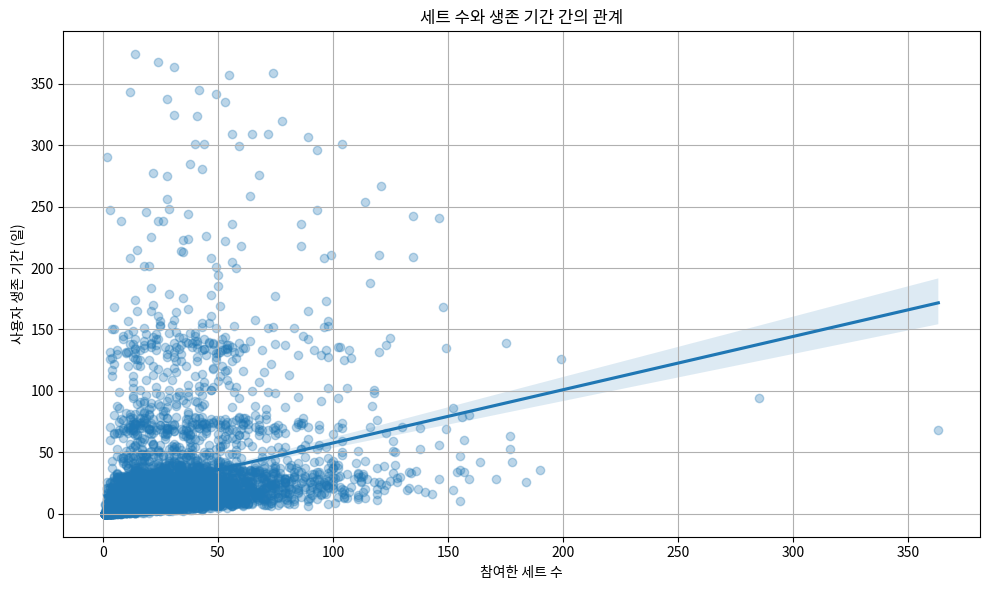

📈 세트 수와 생존 기간 간 상관계수: 0.280


In [ ]:
## 세트 수와 생존 기간 간의 관계 분석
# 1. user_qr_cnt에서 사용자별 세트 수 계산  
# 1. 사용자별 세트 수 계산
user_set_count = user_qr_cnt.groupby('user_id')['set_id'].nunique().reset_index(name='set_count')

# 2. user_lifespan과 병합
user_set_lifespan = pd.merge(user_lifespan[['user_id', 'duration_days']], user_set_count, on='user_id')

# 3. 시각화 (산점도 + 회귀선)
plt.figure(figsize=(10, 6))
sns.regplot(data=user_set_lifespan, x='set_count', y='duration_days', scatter_kws={'alpha': 0.3})
plt.xlabel('참여한 세트 수')
plt.ylabel('사용자 생존 기간 (일)')
plt.title('세트 수와 생존 기간 간의 관계')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. 상관계수 계산
correlation = user_set_lifespan['set_count'].corr(user_set_lifespan['duration_days'])
print(f"📈 세트 수와 생존 기간 간 상관계수: {correlation:.3f}")

In [ ]:
# 완주여부에 따른 이탈율

# 1. 완주 여부 계산 (1개 이상 question_cnt == 10 세트를 가진 유저 → 완주자)
complete_users = user_qr_cnt[user_qr_cnt['question_cnt'] == 10]['user_id'].unique()
user_lifespan['complete'] = user_lifespan['user_id'].isin(complete_users)

# 2. 이탈 여부는 user_lifespan['event_observed']에서 이미 존재 (True = 이탈함)
# 이탈률 계산 (event_observed == True인 비율)

# 3. 그룹별 이탈률 계산
churn_rate = user_lifespan.groupby('complete')['event_observed'].mean().reset_index()
churn_rate.columns = ['complete', 'churn_rate']
churn_rate['complete'] = churn_rate['complete'].map({True: '완주자', False: '미완주자'})

# 출력
print(churn_rate)


  complete  churn_rate
0     미완주자    1.000000
1      완주자    0.999736


### polls_question 기초 EDA 시각화 

In [ ]:
question = pd.read_csv('./data/polls_question.csv', encoding='utf-8')
question.head()

,id,question_text,created_at
0,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53
1,100,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?",2023-03-31 15:22:53
2,101,미래의 틱톡커는?,2023-03-31 15:22:54
3,102,여기서 제일 특이한 친구는?,2023-03-31 15:22:54
4,103,가장 지켜주고 싶은 사람은?,2023-03-31 15:22:55


In [ ]:
question.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5025 entries, 0 to 5024
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             5025 non-null   int64 
 1   question_text  5025 non-null   object
 2   created_at     5025 non-null   object
dtypes: int64(1), object(2)
memory usage: 117.9+ KB


In [ ]:
# created_at 컬럼 datetime으로 변환하기
question['created_at'] = pd.to_datetime(question['created_at'])

In [ ]:
# created_at에서 날짜만 추출하기 
question['date'] = question['created_at'].dt.date

# 날짜별 질문 수 집계하기 
daily_question_cnt = question.groupby('date')['id'].count().reset_index(name='question_cnt')

daily_question_cnt

,date,question_cnt
0,2023-03-31,73
1,2023-04-01,154
2,2023-05-02,235
3,2023-05-04,1
4,2023-05-11,91
5,2023-05-15,982
6,2023-06-02,1523
7,2023-06-06,1966


In [ ]:
question['date'].nunique()

8

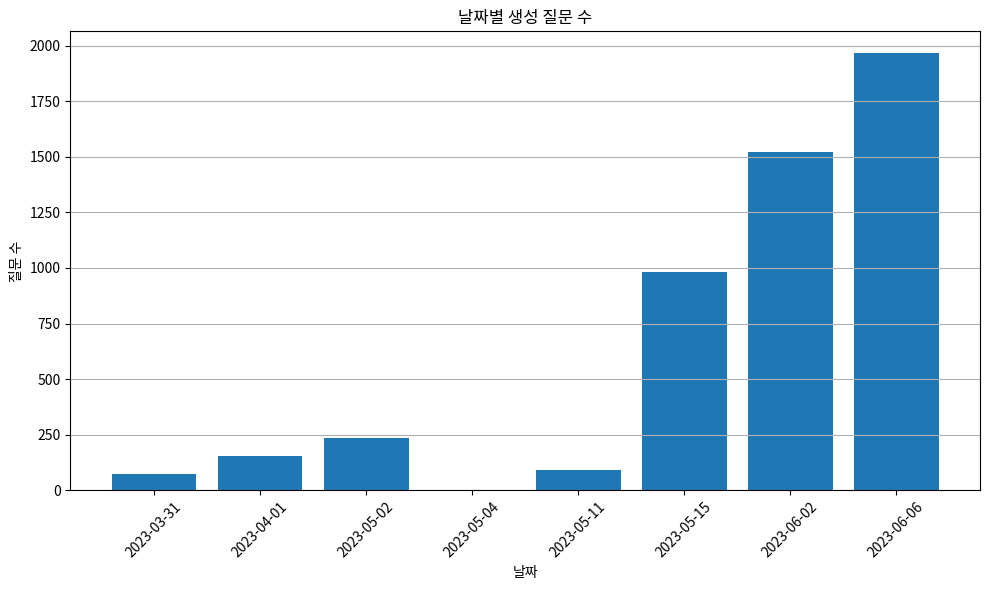

In [ ]:
# 날짜별 질문 수 집계 시각화하기
plt.figure(figsize=(10, 6))
plt.bar(daily_question_cnt['date'].astype(str), daily_question_cnt['question_cnt'])  # x축을 문자열로 변환하여 보기 좋게 표시
plt.title("날짜별 생성 질문 수")
plt.xlabel("날짜")
plt.ylabel("질문 수")
plt.xticks(rotation=45)  # 날짜가 겹치지 않도록 회전
plt.tight_layout()
plt.grid(axis='y')
plt.show()